In [1764]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import requests
from bs4 import BeautifulSoup
import re
import time
import patsy
import datetime
import dateutil
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn import preprocessing
import scipy.stats as stats

%matplotlib inline

In [2]:
print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)

Pandas version: 0.20.1
Numpy version: 1.12.1


In [3]:
pd.set_option('display.max_colwidth', -1)

### First get the list of current U.S. Representatives, as well as links to their Wikipedia pages

In [239]:
# get the html from the webpage
url = 'https://en.wikipedia.org/wiki/Current_members_of_the_United_States_House_of_Representatives'

response = requests.get(url)

In [240]:
# confirm request success
response.status_code

200

In [241]:
# convert the response to a beautifulSoup object
page = response.text
soup = BeautifulSoup(page,"lxml")

In [242]:
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Current members of the United States House of Representatives - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Current_members_of_the_United_States_House_of_Representatives","wgTitle":"Current members of the United States House of Representatives","wgCurRevisionId":790663594,"wgRevisionId":790663594,"wgArticleId":12498224,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with hCards","114th United States Congress","Lists of current office-holders in the United States","Lists of members of the United States House of

In [499]:
# make list of lists to collect Representative link information
rep_links = [['name', 'district', 'wiki_link']]

In [500]:
# get the Representative information and save it as a list
for item in soup.find(class_='sortable wikitable').find_all(class_='fn'):
    rep_links.append([item.text, item.parent.parent.parent.find('a').text, item.find('a')['href']])

In [512]:
# check out the data
len(rep_links)

436

In [502]:
# check out the data
rep_links[3:7]

[['Mike Rogers', 'Alabama 3', '/wiki/Mike_Rogers_(Alabama_politician)'],
 ['Robert Aderholt', 'Alabama 4', '/wiki/Robert_Aderholt'],
 ['Mo Brooks', 'Alabama 5', '/wiki/Mo_Brooks'],
 ['Gary Palmer', 'Alabama 6', '/wiki/Gary_Palmer_(politician)']]

In [504]:
# missing one district, Utah 3, which was recently vacated. Add back in this dude for completeness
rep_links.insert(400, ['Jason Chaffetz', 'Utah 3', '/wiki/Jason_Chaffetz'])

In [513]:
# convert the links to a dataFrame
df_links = pd.DataFrame(rep_links[1:], columns=rep_links[:1][0])

In [514]:
# check out the data
df_links.head(5)

name   district                               wiki_link
0  Bradley Byrne    Alabama 1  /wiki/Bradley_Byrne                   
1  Martha Roby      Alabama 2  /wiki/Martha_Roby                     
2  Mike Rogers      Alabama 3  /wiki/Mike_Rogers_(Alabama_politician)
3  Robert Aderholt  Alabama 4  /wiki/Robert_Aderholt                 
4  Mo Brooks        Alabama 5  /wiki/Mo_Brooks

In [508]:
# save Representative links as .csv in case need to reference in future
np.savetxt("rep_links.csv", rep_links, delimiter=",", fmt='%s')

### Go to Representatives' Wikipedia pages and scrape for biographical data

In [12]:
def generateRepUrl(rep_wiki_link: str):
    """Generates a url to a Representative's Wikipedia page"""
    return 'https://en.wikipedia.org%s' % rep_wiki_link

In [1254]:
# test generateRepUrl function
generateRepUrl(df_links['wiki_link'][1])

'https://en.wikipedia.org/wiki/Martha_Roby'

In [1255]:
# get a Wikipedia page to figure out how to scrape the data
response = requests.get(generateRepUrl(df_links['wiki_link'][1]))
response.status_code

200

In [1257]:
# convert to BeautifulSoup and take a look
rep_page = response.text
rep_soup = BeautifulSoup(rep_page,"lxml")
print(rep_soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Martha Roby - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Martha_Roby","wgTitle":"Martha Roby","wgCurRevisionId":789460234,"wgRevisionId":789460234,"wgArticleId":29218153,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["All articles with dead external links","Articles with dead external links from July 2017","Wikipedia pending changes protected pages (level 1)","All articles with unsourced statements","Articles with unsourced statements from May 2017","Articles with DMOZ links","1976 births","21st-century American polit

In [24]:
# it looks like all the data is contained within an "infobox vcard", so let's zoom in on that
infobox = rep_soup.find(class_='infobox vcard')
infobox

<table class="infobox vcard" style="width:22em">
<tr>
<th colspan="2" style="text-align:center;font-size:125%;font-weight:bold;font-size: 130%;"><span class="fn">Bradley Byrne</span></th>
</tr>
<tr>
<td colspan="2" style="text-align:center"><a class="image" href="/wiki/File:Rep_Bradley_Byrne.jpg"><img alt="Rep Bradley Byrne.jpg" data-file-height="4256" data-file-width="2832" height="331" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Rep_Bradley_Byrne.jpg/220px-Rep_Bradley_Byrne.jpg" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Rep_Bradley_Byrne.jpg/330px-Rep_Bradley_Byrne.jpg 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Rep_Bradley_Byrne.jpg/440px-Rep_Bradley_Byrne.jpg 2x" width="220"/></a></td>
</tr>
<tr>
<td colspan="2" style="text-align:center"></td>
</tr>
<tr>
<th colspan="2" style="text-align:center;background:lavender">Member of the <span style="display: inline-block;"><a href="/wiki/United_States_House_of_Representatives" title="United Stat

In [25]:
# do a tiny bit of formatting to make everything easier to see, and see specifically what the .text returns for each item
for table_row in infobox.find_all('tr'):
    for table_header in table_row.find_all('th'):
        print(str(table_header) + '\n' + table_header.text + '\n')
    for table_data in table_row.find_all('td'):
        print(str(table_data) + '\n' + table_data.text + '\n')

<th colspan="2" style="text-align:center;font-size:125%;font-weight:bold;font-size: 130%;"><span class="fn">Bradley Byrne</span></th>
Bradley Byrne

<td colspan="2" style="text-align:center"><a class="image" href="/wiki/File:Rep_Bradley_Byrne.jpg"><img alt="Rep Bradley Byrne.jpg" data-file-height="4256" data-file-width="2832" height="331" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Rep_Bradley_Byrne.jpg/220px-Rep_Bradley_Byrne.jpg" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Rep_Bradley_Byrne.jpg/330px-Rep_Bradley_Byrne.jpg 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Rep_Bradley_Byrne.jpg/440px-Rep_Bradley_Byrne.jpg 2x" width="220"/></a></td>


<td colspan="2" style="text-align:center"></td>


<th colspan="2" style="text-align:center;background:lavender">Member of the <span style="display: inline-block;"><a href="/wiki/United_States_House_of_Representatives" title="United States House of Representatives">U.S. House of Representatives</a></span

In [1266]:
def generateBeautifulSoup(rep_url):
    """Gets the soup object from the HTML"""
    response = requests.get(rep_url)
    
    if(response.status_code != 200):
        return -1
    else:
        rep_page = response.text
        return BeautifulSoup(rep_page,"lxml")

In [1269]:
def generateInfobox(rep_soup):
    """Gets the infobox vard object from the BeautifulSoup object"""
    
    infobox = rep_soup.find(class_='infobox vcard')
    return infobox

In [1316]:
test_soup = generateBeautifulSoup('https://en.wikipedia.org/wiki/Mark_Takano')

In [1321]:
test_soup.find(id=lambda x: x and 'early' in x.lower()).find_next('p')

<p>Takano was born in 1960 in <a href="/wiki/Riverside,_California" title="Riverside, California">Riverside</a>, California.<sup class="reference" id="cite_ref-pe_1-0"><a href="#cite_note-pe-1">[1]</a></sup> His family was <a class="mw-redirect" href="/wiki/Japanese_American_internment" title="Japanese American internment">relocated and interned</a> from California to a "War Relocation Camp" during <a href="/wiki/World_War_II" title="World War II">World War II</a>.<sup class="reference" id="cite_ref-blade_2-0"><a href="#cite_note-blade-2">[2]</a></sup> He is <i><a href="/wiki/Sansei" title="Sansei">Sansei</a></i>, that is, the grandson of people born in Japan who immigrated to the United States.<sup class="reference" id="cite_ref-3"><a href="#cite_note-3">[3]</a></sup> He attended <a href="/wiki/La_Sierra_High_School" title="La Sierra High School">La Sierra High School</a> of the <a href="/wiki/Alvord_Unified_School_District" title="Alvord Unified School District">Alvord Unified School

In [1323]:
def get_gender(rep_soup):
    male_pronouns = ['he', 'his', 'him']
    female_pronouns = ['she', 'hers', 'her', 'congresswoman']
    male_count = 0
    female_count = 0

    summary_str = str(rep_soup.find(class_='toc').find_all_previous('p')).lower()
    
    if rep_soup.find(id=lambda x: x and 'early' in x.lower()):
        early_life_str = str(rep_soup.find(id=lambda x: x and 'early' in x.lower()).find_next('p')).lower()
    elif rep_soup.find(id=lambda x: x and 'background' in x.lower()):
        early_life_str = str(rep_soup.find(id=lambda x: x and 'background' in x.lower()).find_next('p')).lower()
    else:
        early_life_str = ''

    for pronoun in male_pronouns:
        male_count += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(pronoun), summary_str))
        male_count += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(pronoun), early_life_str))

    for pronoun in female_pronouns:
        female_count += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(pronoun), summary_str))
        female_count += sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(pronoun), early_life_str))

    if male_count > female_count:
        return 1
    elif female_count > male_count:
        return 0
    else:
        return None

In [1264]:
def generateRepData(rep_soup, rep_name):
    """Parses the Representative's vcard for specific biographical information.
    This function is a result of many testing iterations"""
    
    rep_data = {}
    rep_data['name'] = rep_name
    degrees = []
    
    infobox = generateInfobox(rep_soup)
    
    for table_row in infobox.find_all('tr'):
        for table_header in table_row.find_all('th'):
            
            # Political Party
            if 'Political party' in table_header.text:
                rep_data['party'] = table_header.next_element.next_element.next_element.text
            
            #Marriage Status
            elif 'Spouse' in table_header.text:
                spouse = table_header.next_element.next_element.next_element.text.lower()
                if 'divorced' in spouse or spouse == 'none':
                    rep_data['married'] = 0
                else: rep_data['married'] = 1
                    
            #Number of Children
            elif 'Children' in table_header.text:
                children = table_header.next_element.next_element.next_element.text.lower()
                if children.isdigit():
                    rep_data['children'] = int(children)
                elif '\n' in children:
                    rep_data['children'] = len(str.splitlines(children))
                else:
                    children = children.split(' ')
                    if children[0] in num_map:
                        rep_data['children'] = num_map[children[0]]
                    elif any(char.isdigit() for char in children[0]):
                        rep_data['children'] = int(children[0][:1])
                    else:
                        try:
                            rep_data['children'] = int(children[0])
                        except ValueError:
                            continue
                            
            #Education (type of degree)
            elif table_header.text == 'Education':
                for item in table_header.next_element.next_element.next_element.find_all('a'):
                    if len(item.text) < 7:
                        degrees.append(item.text.replace('.', ''))
                        
            #Occupation
            elif 'Occupation' in table_header.text:
                rep_data['occupation'] = table_header.next_element.next_element.next_element.text
                
            #Date assumed office
            elif 'U.S. House of Representatives' in table_header.text:
                if table_header.find_next('tr').find_next('tr').find('br'):
                    rep_data['assumed_office'] = table_header.find_next('tr').find_next('tr').find('br').next_sibling.strip()
        for table_data in table_row.find_all('td'):
            
            #Birthday
            if table_data.find(class_='bday'):
                rep_data['birthday'] = table_data.find(class_='bday').text
                
    # get gender
    rep_data['male'] = get_gender(rep_soup)
    
    # Assign NoneType to variable if it wasn't found on the Wikipedia page
    if 'assumed_office' not in rep_data: 
        rep_data['assumed_office'] = None
    if 'birthday' not in rep_data: 
        rep_data['birthday'] = None
    if 'children' not in rep_data: 
        rep_data['children'] = None
    if 'married' not in rep_data: 
        rep_data['married'] = None
    if 'party' not in rep_data: 
        rep_data['party'] = None
    if 'occupation' not in rep_data: 
        rep_data['occupation'] = None
        
    if degrees:
        rep_data['education'] = degrees
    else:
        rep_data['education'] = None
    
    return rep_data

In [28]:
# some children counts use words instead of numbers, so create this mapping to convert words to numbers
num_map = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10}

In [1271]:
# test generateRepData function
sample_rep = generateRepData(generateBeautifulSoup(generateRepUrl(df_links['wiki_link'][224])), df_links['name'][224])
sample_rep

{'assumed_office': 'January 3, 2001',
 'birthday': '1956-07-27',
 'children': None,
 'education': None,
 'male': 1,
 'married': 0,
 'name': 'William Clay',
 'occupation': 'Paralegal',
 'party': 'Democratic'}

In [1272]:
# generate main dataFrame
column_values = ['name', 'assumed_office', 'birthday', 'children', 'married', 'party', 'education', 'occupation', 'male']
df_rep = pd.DataFrame(columns=column_values, index=range(435))

In [1324]:
# collect the Representative data and fill up the dataFrame

start_time = datetime.datetime.now().time() # track time it takes to complete task
print('Start time:', start_time) 
count = 0

for i in range(435):
    time.sleep(.25) #sleep for a time, so as not to get rejected from Wikipedia
    if count >= 50 and count % 50 == 0:
        print('At value ', count, ': ', datetime.datetime.now().time(), sep='')
        
    try:
        rep_data = generateRepData(generateBeautifulSoup(generateRepUrl(df_links['wiki_link'][i])), df_links['name'][i])
    
        df_rep.iloc[i] = pd.Series({'name': rep_data['name'], 'assumed_office': rep_data['assumed_office'],
                                    'birthday': rep_data['birthday'], 'children': rep_data['children'], 
                                    'married': rep_data['married'], 'party': rep_data['party'],
                                    'education': rep_data['education'], 'occupation': rep_data['occupation'],
                                    'male': rep_data['male']})
        count += 1
    except ValueError as error:
        print(i, ', ', df_links['wiki_link'][i], ', ', error, sep='')
    except AttributeError as error:
        print(i, ', ', df_links['wiki_link'][i], ', ', error, sep='')
        
print('End time:', datetime.datetime.now().time())

Start time: 10:15:00.933896
At value 50: 10:15:34.369667
At value 100: 10:16:04.804352
At value 150: 10:16:36.785419
At value 200: 10:17:10.752568
At value 250: 10:17:42.892100
At value 300: 10:18:13.734747
At value 350: 10:18:43.251607
At value 400: 10:19:12.798005
End time: 10:19:34.035062


In [1294]:
# check out the data
df_rep.sample(10)

name   assumed_office    birthday children married  \
280  John Katko              January 3, 2015  1962-11-09  None     None     
376  Beto O'Rourke           January 3, 2013  1972-09-26  3        1        
168  Brett Guthrie           January 3, 2009  1964-02-18  None     1        
397  Rob Bishop              January 3, 2003  1951-07-13  5        1        
350  Tom Rice                January 3, 2013  1957-08-04  3        1        
24   Tom McClintock          January 3, 2009  1956-07-10  2        1        
254  Michelle Lujan Grisham  January 3, 2013  1959-10-24  2        1        
417  Cathy McMorris Rodgers  January 3, 2005  1969-05-22  3        1        
177  Ralph Abraham           January 3, 2015  1954-09-16  3        1        
10   Raúl Grijalva           January 3, 2013  1948-02-19  3        1        

          party     education                                  occupation  \
280  Republican  None          None                                         
376  Democratic  [BA]          None                                         
168  Republican  None          None                                         
397  Republican  [BA]          None                                         
350  Republican  [BS, MA, JD]  None                                         
24   Republican  [BA]          None                                         
254  Democratic  [BS, JD]      None                                         
417  Republican  [BA, MBA]     None                                         
177  Republican  None          \n\n\nPhysician\nFormer veterinarian\n\n\n   
10   Democratic  [BA]          None                                         

     male  
280  1     
376  1     
168  1     
397  1     
350  1     
24   1     
254  0     
417  0     
177  None  
10   1

In [1326]:
df[pd.isnull(df.male)]

name   assumed_office    birthday children married  \
138  Danny K. Davis     January 3, 1997  1941-09-06  2        1        
162  Steve King         January 3, 2013  1949-05-28  3        1        
241  Ann McLane Kuster  January 3, 2013  1956-09-05  2        1        
296  Ted Budd           January 3, 2017  1971-10-21  3        1        
412  Gerry Connolly     January 3, 2009  1950-03-30  None     1        

          party education               occupation  male           district  \
138  Democratic  None      None                     None  Illinois 7          
162  Republican  None      None                     None  Iowa 4              
241  Democratic  None      None                     None  New Hampshire 2     
296  Republican  None      Farmer, gun store owner  None  North Carolina 13   
412  Democratic  None      None                     None  Virginia 11         

                   wiki_link  
138  /wiki/Danny_K._Davis     
162  /wiki/Steve_King         
241  /wiki/Ann_McLane_Kuster  
296  /wiki/Ted_Budd           
412  /wiki/Gerry_Connolly

In [ ]:
df.set_value(138, 'male', 1)
df.set_value(162, 'male', 1)
df.set_value(241, 'male', 0)
df.set_value(296, 'male', 1)
df.set_value(412, 'male', 1)

In [521]:
# pickle the concatenated dateFrame for future use, if necessary
pickle.dump(df_rep, open("df_rep_pickle.p", "wb"))

In [1325]:
# merge the two dataFrames so we can easily access links as needed
df = df_rep.merge(df_links, on='name', how='left')

In [1328]:
# checkout the data
df.sample(5)

name     assumed_office    birthday children married  \
104  Brian Mast            January 3, 2017    1980-07-10  None     None     
214  Erik Paulsen          January 3, 2009    1965-05-14  None     1        
159  Rod Blum              January 3, 2015    1955-04-26  5        None     
308  Marcia Fudge          November 18, 2008  1952-10-29  None     None     
86   Lisa Blunt Rochester  January 3, 2017    1962-02-10  2        1        

                             party  education  \
104  Republican                     None        
214  Republican Party of Minnesota  None        
159  Republican                     [BA, MBA]   
308  Democratic                     None        
86   Democratic                     None        

                          occupation male           district  \
104  Military veteran and politician  1    Florida 18          
214  Business analyst                 1    Minnesota 3         
159  None                             1    Iowa 1              
308  None                             0    Ohio 11             
86   None                             0    Delaware At Large   

                      wiki_link  
104  /wiki/Brian_Mast            
214  /wiki/Erik_Paulsen          
159  /wiki/Rod_Blum              
308  /wiki/Marcia_Fudge          
86   /wiki/Lisa_Blunt_Rochester

### Now clean the data


In [1331]:
# check and see if any 'party' value is not Democratic or Republican
df[(df.party != 'Republican') & (df.party != 'Democratic')]

name     assumed_office    birthday children married  \
0    Bradley Byrne   December 17, 2013  1955-02-16  4        1        
8    Tom O'Halleran  January 3, 2017    1946-01-24  None     1        
99   Charlie Crist   January 3, 2017    1956-07-24  None     1        
169  John Yarmuth    January 3, 2007    1947-11-04  1        1        
209  Debbie Dingell  January 3, 2015    1953-11-23  None     1        
214  Erik Paulsen    January 3, 2009    1965-05-14  None     1        
215  Betty McCollum  January 3, 2001    1954-07-12  None     0        
219  Rick Nolan      January 3, 2013    1943-12-17  None     0        
245  Chris Smith     January 3, 1981    1953-03-04  None     1        
249  Albio Sires     January 3, 2013    1951-01-26  None     1        
260  Kathleen Rice   January 3, 2015    1965-02-15  None     None     
282  Brian Higgins   January 3, 2013    1959-10-06  2        1        
286  Walter Jones    January 3, 1995    1943-02-10  None     1        
374  Randy Weber     January 3, 2013    1953-07-02  3        1        
399  Jason Chaffetz  None               1967-03-26  3        1        
425  Evan Jenkins    January 3, 2015    1960-09-12  3        1        

                                                               party  \
0    Democratic (Before 1998)\nRepublican (1998–present)               
8    Democratic (2015–present)                                         
99   Democratic (2012–present)                                         
169  Republican (Before 1985)\nDemocratic (1985–present)               
209  Republican (Before 1981)\nDemocratic (1981–present)               
214  Republican Party of Minnesota                                     
215  Democratic-Farmer-Labor Party                                     
219  Minnesota Democratic–Farmer–Labor Party                           
245  Democratic (Before 1978)\nRepublican (1978–present)               
249  Democratic (1969-1985, 1998-present)                              
260  Republican (Before 2005)\nDemocratic (2005–present)               
282  Democratic[1]                                                     
286  Republican (1994–present)                                         
374  Republican (1990–present)                                         
399  Republican (1990–present)                                         
425  Republican (Before 1992,\n2013–present)\nDemocratic (1992–2013)   

    education            occupation male          district  \
0    [BA, JD]  None                  1    Alabama 1          
8    None      None                  1    Arizona 1          
99   [BA, JD]  None                  1    Florida 13         
169  [BA]      None                  1    Kentucky 3         
209  None      None                  0    Michigan 12        
214  None      Business analyst      1    Minnesota 3        
215  None      None                  0    Minnesota 4        
219  None      None                  1    Minnesota 8        
245  [BS]      None                  1    New Jersey 4       
249  None      insurance executive   1    New Jersey 8       
260  [BA, JD]  None                  0    New York 4         
282  None      Public Official       1    New York 26        
286  None      Business Distributor  1    North Carolina 3   
374  None      None                  1    Texas 14           
399  [BA]      None                  1    Utah 3             
425  [BS, JD]  None                  1    West Virginia 3    

                                     wiki_link  
0    /wiki/Bradley_Byrne                        
8    /wiki/Tom_O%27Halleran                     
99   /wiki/Charlie_Crist                        
169  /wiki/John_Yarmuth                         
209  /wiki/Debbie_Dingell                       
214  /wiki/Erik_Paulsen                         
215  /wiki/Betty_McCollum                       
219  /wiki/Rick_Nolan                           
245  /wiki/Chris_Smith_(New_Jersey_politician)  
249  /wiki/Albio_Sires               

In [1332]:
df.set_value(0, 'party', 'Republican')
df.set_value(8, 'party', 'Democratic')
df.set_value(99, 'party', 'Democratic')
df.set_value(169, 'party', 'Democratic')
df.set_value(209, 'party', 'Democratic')
df.set_value(214, 'party', 'Republican')
df.set_value(215, 'party', 'Democratic')
df.set_value(219, 'party', 'Democratic')
df.set_value(245, 'party', 'Republican')
df.set_value(249, 'party', 'Democratic')
df.set_value(260, 'party', 'Democratic')
df.set_value(282, 'party', 'Democratic')
df.set_value(286, 'party', 'Republican')
df.set_value(374, 'party', 'Republican')
df.set_value(399, 'party', 'Republican')
df.set_value(425, 'party', 'Republican')

name     assumed_office    birthday children married  \
0    Bradley Byrne           December 17, 2013  1955-02-16  4        1        
1    Martha Roby             January 3, 2011    1976-07-26  2        1        
2    Mike Rogers             January 3, 2003    1958-07-16  None     1        
3    Robert Aderholt         January 3, 1997    1965-07-22  None     1        
4    Mo Brooks               January 3, 2011    1954-04-29  4        1        
5    Gary Palmer             January 3, 2015    1954-05-14  None     None     
6    Terri Sewell            January 3, 2011    1965-01-01  None     None     
7    Don Young               March 6, 1973      1933-06-09  2        1        
8    Tom O'Halleran          January 3, 2017    1946-01-24  None     1        
9    Martha McSally          January 3, 2015    1966-03-22  None     None     
10   Raúl Grijalva           January 3, 2013    1948-02-19  3        1        
11   Paul Gosar              January 3, 2013    1958-11-27  3        1        
12   Andy Biggs              January 3, 2017    1958-11-07  None     None     
13   David Schweikert        January 3, 2013    1962-03-03  None     1        
14   Ruben Gallego           January 3, 2015    1979-11-20  None     1        
15   Trent Franks            January 3, 2013    1957-06-19  2        1        
16   Kyrsten Sinema          January 3, 2013    1976-07-12  None     None     
17   Rick Crawford           January 3, 2011    1966-01-22  2        1        
18   French Hill             January 3, 2015    1956-12-05  None     None     
19   Steve Womack            January 3, 2011    1957-02-18  None     1        
20   Bruce Westerman         January 3, 2015    1967-11-18  4        1        
21   Doug LaMalfa            January 3, 2013    1960-07-02  4        1        
22   Jared Huffman           January 3, 2013    1964-02-18  2        1        
23   John Garamendi          November 3, 2009   1945-01-24  6        1        
24   Tom McClintock          January 3, 2009    1956-07-10  2        1        
25   Mike Thompson           January 3, 2013    1951-01-24  2        1        
26   Doris Matsui            January 3, 2013    1944-09-25  1        1        
27   Ami Bera                January 3, 2013    1965-03-02  1        1        
28   Paul Cook               January 3, 2013    1943-03-03  None     1        
29   Jerry McNerney          January 3, 2013    1951-06-18  3        1        
..              ...                      ...           ... ..       ..        
405  Donald McEachin         January 3, 2017    1961-10-10  None     1        
406  Thomas Garrett, Jr.     January 3, 2017    1972-03-27  2        1        
407  Bob Goodlatte           January 3, 1993    1952-09-22  None     1        
408  Dave Brat               November 4, 2014   1964-07-27  2        1        
409  Don Beyer               January 3, 2015    1950-06-20  4        1        
410  Morgan Griffith         January 3, 2011    1958-03-15  3        1        
411  Barbara Comstock        January 3, 2015    1959-06-30  3        1        
412  Gerry Connolly          January 3, 2009    1950-03-30  None     1        
413  Suzan DelBene           November 6, 2012   1962-02-17  2        1        
414  Rick Larsen             January 3, 2001    1965-06-15  None     1        
415  Jaime Herrera Beutler   January 3, 2011    1978-11-03  None     1        
416  Dan Newhouse            January 3, 2015    1955-07-10  None     1        
417  Cathy McMorris Rodgers  January 3, 2005    1969-05-22  3        1        
418  Derek Kilmer            January 3, 2013    1974-01-01  None     1        
419  Pramila Jayapal         January 3, 2017    1965-09-21  1        1        
420  Dave Reichert           January 3, 2005    1950-08-29  3        1        
421  Adam Smith              January 3, 1997    1965-06-15  2        1        
422  Dennis Heck             January 3, 2013    1952-07-29  2        1        
423  David McKinley          January 3, 2011    1947-03-28  4        1   

In [711]:
# create dummy column based on party affiliation
def assign_republican_function(row):
    """Returns 1 if party affiliation is Republican, 0 otherwise"""
    if row['party'] == 'Republican':
        return 1
    else:
        return 0

In [1337]:
df.insert(6, 'republican', 0)
df['republican'] = df.apply(assign_republican_function, axis=1)

In [1338]:
df.sample(5)

name     assumed_office    birthday children married  \
136  Mike Quigley      April 7, 2009      1958-10-17  None     1        
70   Duncan D. Hunter  January 3, 2013    1976-12-07  3        1        
128  Colleen Hanabusa  November 14, 2016  1951-05-04  None     1        
157  Larry Bucshon     January 3, 2011    1962-05-31  4        1        
181  Andy Harris       January 3, 2011    1957-01-25  None     1        

          party  republican      education     occupation male       district  \
136  Democratic  0           None           Lawyer         1    Illinois 5      
70   Republican  1           None           None           1    California 50   
128  Democratic  0           None           None           0    Hawaii 1        
157  Republican  1           None           Heart Surgeon  1    Indiana 8       
181  Republican  1           [BS, MD, MHS]  None           1    Maryland 1      

                           wiki_link  
136  /wiki/Mike_Quigley_(politician)  
70   /wiki/Duncan_D._Hunter           
128  /wiki/Colleen_Hanabusa           
157  /wiki/Larry_Bucshon              
181  /wiki/Andy_Harris_(politician)

In [1339]:
# convert the children count to numeric
df.children = pd.to_numeric(df.children)

In [1340]:
# see if any 'assumed_office' values are missing
df[pd.isnull(df.assumed_office)]

name assumed_office    birthday  children married       party  \
180  Bruce Poliquin  None           1953-11-01 NaN        None    Republican   
399  Jason Chaffetz  None           1967-03-26  3.0       1       Republican   

     republican education occupation male district             wiki_link  
180  1           None      None       1    Maine 2  /wiki/Bruce_Poliquin  
399  1           [BA]      None       1    Utah 3   /wiki/Jason_Chaffetz

In [1341]:
# set the value after manually going to Wikipedia page to get value
df.set_value(180, 'assumed_office', 'January 3, 2015')
df.set_value(399, 'assumed_office', 'January 3, 2015')
df[pd.isnull(df.assumed_office)]

Empty DataFrame
Columns: [name, assumed_office, birthday, children, married, party, republican, education, occupation, male, district, wiki_link]
Index: []

In [1342]:
# convert 'assumed_office' date values to numeric datetime.date objects
df['assumed_office'] = df.assumed_office.apply(dateutil.parser.parse)
df['assumed_office'] = df.assumed_office.apply(lambda x: x.date())

In [1343]:
# confirm that all birthdays are accounted for
df[pd.isnull(df.birthday)]

Empty DataFrame
Columns: [name, assumed_office, birthday, children, married, party, republican, education, occupation, male, district, wiki_link]
Index: []

In [1344]:
# convert 'birthday' date values to numeric datetime.date objects
df['birthday'] = df.birthday.apply(dateutil.parser.parse)
df['birthday'] = df.birthday.apply(lambda x: x.date())

In [1345]:
# check out a list of degrees and see how common they are
degrees = defaultdict(int)

for item in df['education']:
    if item:
        for degree in item:
            degrees[degree] += 1
   
degrees

defaultdict(int,
            {'AA': 1,
             'BA': 122,
             'BBA': 4,
             'BEng': 1,
             'BLS': 1,
             'BM': 1,
             'BS': 32,
             'BSN': 2,
             'DDS': 1,
             'DVM': 1,
             'EdD': 2,
             'JD': 62,
             'LLB': 3,
             'MA': 22,
             'MBA': 13,
             'MD': 3,
             'MDiv': 2,
             'MFA': 1,
             'MHS': 1,
             'MPA': 5,
             'MPH': 1,
             'MPP': 3,
             'MPhil': 1,
             'MS': 8,
             'PhD': 5})

In [1346]:
# it seems like the only way to use the degree data is to make some sort of boolean variable, like, has_degree
# we'll do two, has_degree (which is more general), and has_jd, since that is also a very common degree
# let's start by confirming that the person with an 'AA' also has a four-year degree so we can just say that has_degree means the person has at least a four-year education
for i in range(df.shape[0]):
    if df.education[i] and 'AA' in df.education[i]:
        print(df.iloc[i])

name              Devin Nunes      
assumed_office    2013-01-03       
birthday          1973-10-01       
children          3                
married           1                
party             Republican       
republican        1                
education         [AA, BS, MS]     
occupation        None             
male              1                
district          California 22    
wiki_link         /wiki/Devin_Nunes
Name: 42, dtype: object


In [1347]:
def assign_degree_function(row):
    """Returns 1 if education field is not empty, 0 otherwise"""
    if row['education']:
        return 1
    else:
        return np.NaN

In [1351]:
# create new has_degree column
df.insert(8, 'has_degree', 0)
df['has_degree'] = df.apply(assign_degree_function, axis=1)

In [1352]:
# check out the data
df.sample(5)

name assumed_office    birthday  children married       party  \
220  Trent Kelly   2015-06-02     1966-03-01 NaN        None    Republican   
229  Sam Graves    2001-01-03     1963-11-07 NaN        None    Republican   
156  André Carson  2008-03-11     1974-10-16 NaN        None    Democratic   
166  Ron Estes     2017-04-25     1956-07-19  3.0       1       Republican   
37   Ro Khanna     2017-01-03     1976-09-13 NaN        None    Democratic   

     republican  education  has_degree  \
220  1           None      NaN           
229  1           None      NaN           
156  0           None      NaN           
166  1           [BS, MBA]  1.0          
37   0           None      NaN           

                                   occupation male       district  \
220  Attorney                                  1    Mississippi 1   
229  None                                      1    Missouri 6      
156  None                                      1    Indiana 7       
166  None                                      1    Kansas 4        
37   Economics Lecturer\nAttorney\nPolitician  1    California 17   

                          wiki_link  
220  /wiki/Trent_Kelly_(politician)  
229  /wiki/Sam_Graves                
156  /wiki/Andr%C3%A9_Carson         
166  /wiki/Ron_Estes                 
37   /wiki/Ro_Khanna

In [1353]:
def assign_jd_degree_function(row):
    """Returns 1 if education field contains a JD, 0 otherwise"""
    if not row['education']:
        return np.NaN
    elif 'JD' in row.education:
        return 1
    else:
        return 0

In [1354]:
# create new has_jd column
df.insert(9, 'has_jd', 0)
df['has_jd'] = df.apply(assign_jd_degree_function, axis=1)

In [1355]:
# check out the data
df.sample(5)

name assumed_office    birthday  children married  \
331  Brian Fitzpatrick  2017-01-03     1973-12-17 NaN        None     
317  Tom Cole           2003-01-03     1949-04-28  1.0       1        
50   Brad Sherman       2013-01-03     1954-10-24 NaN        1        
103  Tom Rooney         2009-01-03     1970-11-21  3.0       1        
427  Mark Pocan         2013-01-03     1964-08-14 NaN        1        

          party  republican     education  has_degree  has_jd  \
331  Republican  1           None         NaN         NaN       
317  Republican  1           None         NaN         NaN       
50   Democratic  0           None         NaN         NaN       
103  Republican  1           [BA, MA, JD]  1.0         1.0      
427  Democratic  0           None         NaN         NaN       

             occupation male        district  \
331  FBI agent, lawyer   1    Pennsylvania 8   
317  None                1    Oklahoma 4       
50   Accountant, lawyer  1    California 30    
103  None                1    Florida 17       
427  Business Owner      1    Wisconsin 2      

                                         wiki_link  
331  /wiki/Brian_Fitzpatrick_(American_politician)  
317  /wiki/Tom_Cole                                 
50   /wiki/Brad_Sherman                             
103  /wiki/Tom_Rooney_(politician)                  
427  /wiki/Mark_Pocan

In [1356]:
def clean_occupation(row):
    if row['occupation']:        
        occupation_text = row.occupation.lower()
        occupation_text = occupation_text.replace('-', '')
        occupation_text = occupation_text.replace(' and', ', ')
        occupation_text = occupation_text.replace('\n', ', ')
        occupation_text = occupation_text.replace(' ,', ',')
        
        occupation_list = occupation_text.split(',')
        for i in range(len(occupation_list)):
            occupation_list[i] = occupation_list[i].strip()
            
        return occupation_list
        
    return None

In [1357]:
df['occupation'] = df.apply(clean_occupation, axis=1)

In [1358]:
df[pd.notnull(df.occupation)]

name assumed_office    birthday  children married  \
16   Kyrsten Sinema     2013-01-03     1976-07-12 NaN        None     
18   French Hill        2015-01-03     1956-12-05 NaN        None     
20   Bruce Westerman    2015-01-03     1967-11-18  4.0       1        
25   Mike Thompson      2013-01-03     1951-01-24  2.0       1        
28   Paul Cook          2013-01-03     1943-03-03 NaN        1        
29   Jerry McNerney     2013-01-03     1951-06-18  3.0       1        
31   Mark DeSaulnier    2015-01-03     1952-03-31 NaN        None     
37   Ro Khanna          2017-01-03     1976-09-13 NaN        None     
38   Anna Eshoo         2013-01-03     1942-12-13  2.0       0        
40   Jimmy Panetta      2017-01-03     1969-10-01  2.0       1        
44   Salud Carbajal     2017-01-03     1964-11-18 NaN        1        
50   Brad Sherman       2013-01-03     1954-10-24 NaN        1        
55   Norma Torres       2015-01-03     1965-04-04 NaN        1        
62   Ken Calvert        2013-01-03     1953-06-08 NaN        0        
67   Alan Lowenthal     2013-01-03     1941-03-08  2.0       0        
71   Juan Vargas        2013-01-03     1961-03-07  2.0       1        
72   Scott Peters       2013-01-03     1958-06-17  2.0       1        
73   Susan Davis        2003-01-03     1944-04-13 NaN        1        
82   Joe Courtney       2007-01-03     1953-04-06 NaN        1        
88   Neal Dunn          2017-01-03     1953-02-16 NaN        None     
89   Ted Yoho           2013-01-03     1955-04-13 NaN        1        
90   John Rutherford    2017-01-03     1952-09-02  2.0       1        
93   Stephanie Murphy   2017-01-03     1978-09-16 NaN        None     
96   Val Demings        2017-01-03     1957-03-12  3.0       1        
104  Brian Mast         2017-01-03     1980-07-10 NaN        None     
105  Francis Rooney     2017-01-03     1953-12-04 NaN        None     
115  Sanford Bishop     1993-01-03     1947-02-04 NaN        1        
116  Drew Ferguson      2017-01-03     1966-11-15  4.0       1        
117  Hank Johnson       2007-01-03     1954-10-02 NaN        1        
123  Jody Hice          2015-01-03     1960-04-22 NaN        None     
..         ...                 ...            ...  ..         ...     
328  Glenn Thompson     2009-01-03     1959-07-27 NaN        1        
331  Brian Fitzpatrick  2017-01-03     1973-12-17 NaN        None     
335  Keith Rothfus      2013-01-03     1962-04-25  6.0       1        
337  Michael Doyle      2003-01-03     1953-08-05 NaN        1        
339  Lloyd Smucker      2017-01-03     1964-01-23 NaN        None     
341  Timothy F. Murphy  2003-01-03     1952-09-11 NaN        1        
343  Jim Langevin       2001-01-03     1964-04-22 NaN        None     
346  Jeff Duncan        2011-01-03     1966-01-07  3.0       1        
353  Jimmy Duncan       1988-11-08     1947-07-21 NaN        1        
359  David Kustoff      2017-01-03     1966-10-08 NaN        1        
362  Ted Poe            2005-01-03     1948-09-10 NaN        1        
364  John Ratcliffe     2015-01-03     1965-10-20 NaN        None     
367  John Culberson     2001-01-03     1956-08-24 NaN        1        
369  Al Green           2005-01-03     1947-09-01 NaN        None     
375  Vicente González   2017-01-03     1967-09-04 NaN        1        
379  Jodey Arrington    2017-01-03     1972-03-09 NaN        1        
386  Michael Burgess    2003-01-03     1950-12-23  3.0       1        
387  Blake Farenthold   2011-01-03     1961-12-12 NaN        1        
389  Gene Green         1993-01-03     1947-10-17 NaN        1        
391  John Carter        2003-01-03     1941-11-06  4.0       1        
393  Marc Veasey        2013-01-03     1971-01-03 NaN        1        
395  Lloyd Doggett      2013-01-03     1946-10-06 NaN        1        
396  Brian Babin        2015-01-03     1948-03-23 NaN        1        
398  Chris Stewart      2013-01-03     1960-07-15  6.0       1        
413  Suzan DelBene      2012-11-06     196

In [1359]:
# check out a list of occupations and see how common they are
occupations = defaultdict(int)

for occupation_list in df['occupation']:
    if occupation_list:
        for occupation in occupation_list:
            occupations[occupation] += 1
   
occupations

defaultdict(int,
            {'': 12,
             '911 dispatcher': 1,
             'accountant': 1,
             'advertising executive': 1,
             'american university washington college of law[1]': 1,
             'assistant business manager': 1,
             'attorney': 26,
             'attorney/consultant': 1,
             'auctioneer': 1,
             'author': 2,
             'banker': 1,
             'business analyst': 1,
             'business consultant': 2,
             'business distributor': 1,
             'business owner': 1,
             'businessman': 4,
             'california state university': 1,
             'car dealer': 1,
             'civil rights leader': 1,
             'college professor': 1,
             'college professor[1]': 1,
             'commercial real estate': 1,
             'communications executive': 1,
             'congressional aide[1]': 1,
             'constitutional attorney': 1,
             'construction company executive': 1,


In [1360]:
# pickle the concatenated dateFrame for future use, if necessary
pickle.dump(df, open("df_pickle.p", "wb"))

In [942]:
# get the pickled df if, for example, restarting the notebook
df = pickle.load(open('df_pickle.p', 'rb'))

### Now bring in the margin of victory in 2014 and 2016, one to use as a control variable, the other as the dependent variable

In [947]:
# get the html from the webpage
margin_2014_url = 'https://ballotpedia.org/Margin_of_victory_analysis_for_the_2014_congressional_elections'
response = requests.get(margin_2014_url)
# confirm request success
print(response.status_code)
# convert the response to a beautifulSoup object
if response.status_code == 200:
    page = response.text
    margin_2014_soup = BeautifulSoup(page,"lxml")

200


In [948]:
print(margin_2014_soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   Margin of victory analysis for the 2014 congressional elections - Ballotpedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   window.RLQ = window.RLQ || []; window.RLQ.push( function () {
mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Margin_of_victory_analysis_for_the_2014_congressional_elections","wgTitle":"Margin of victory analysis for the 2014 congressional elections","wgCurRevisionId":5947927,"wgRevisionId":5947927,"wgArticleId":584114,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Congressional news, 2015","January 2015"],"wgBreakFrames":!1,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransform

In [949]:
# get the table containing the margins of victory
margin_table_2014 = margin_2014_soup.find(text=re.compile('^District$')).parent.parent.parent.parent

In [950]:
# do a tiny bit of formatting to make everything easier to see, and see specifically what the .text returns for each item
for table_row in margin_table_2014.find_all('tr'):
    for table_header in table_row.find_all('th'):
        print(str(table_header) + '\n' + table_header.text + '\n')
    for table_data in table_row.find_all('td'):
        print(str(table_data) + '\n' + table_data.text + '\n')

<th colspan="5" style="background-color:#008000; color: white;"><b>Margin of Victory in 2014 United States House of Representatives Elections</b>
</th>
Margin of Victory in 2014 United States House of Representatives Elections


<th style="background-color:#444; color: white;"><b>District</b>
</th>
District


<th style="background-color:#444; color: white;"><b>Winner</b>
</th>
Winner


<th style="background-color:#444; color: white;"><b>Margin of Victory</b>
</th>
Margin of Victory


<th style="background-color:#444; color: white;"><b>Total Vote</b>
</th>
Total Vote


<th style="background-color:#444; color: white;"><b>Top Opponent</b>
</th>
Top Opponent


<td> Alabama District 1 </td>
 Alabama District 1 

<td> <a href="/Republican_Party" title="Republican Party"><img alt="Republican Party" data-file-height="16" data-file-width="16" height="18" src="https://cdn.ballotpedia.org/images/f/fd/Ends.png" width="18"/></a> <a href="/Bradley_Byrne" title="Bradley Byrne">Bradley Byrne</a></td>


<td><a href="/Wesley_Neuman" title="Wesley Neuman">Wesley Neuman</a>
</td>
Wesley Neuman


<td> Florida District 8 </td>
 Florida District 8 

<td> <a href="/Republican_Party" title="Republican Party"><img alt="Republican Party" data-file-height="16" data-file-width="16" height="18" src="https://cdn.ballotpedia.org/images/f/fd/Ends.png" width="18"/></a> <a href="/Bill_Posey" title="Bill Posey">Bill Posey</a></td>
  Bill Posey

<td>31.7%</td>
31.7%

<td>274,513</td>
274,513

<td><a href="/Gabriel_Rothblatt" title="Gabriel Rothblatt">Gabriel Rothblatt</a>
</td>
Gabriel Rothblatt


<td> Florida District 9 </td>
 Florida District 9 

<td> <a href="/Democratic_Party" title="Democratic Party"><img alt="Democratic Party" data-file-height="16" data-file-width="16" height="18" src="https://cdn.ballotpedia.org/images/d/d4/Electiondot.png" width="18"/></a> <a href="/Alan_Grayson" title="Alan Grayson">Alan Grayson</a></td>
  Alan Grayson

<td>10.9%</td>
10.9%

<td>173,878</td>
173,878

<td><a href

<td>68%</td>
68%

<td>113,226</td>
113,226

<td><a href="/Ross_Brady" title="Ross Brady">Ross Brady</a>
</td>
Ross Brady


<td> New York District 11 </td>
 New York District 11 

<td> <a href="/Republican_Party" title="Republican Party"><img alt="Republican Party" data-file-height="16" data-file-width="16" height="18" src="https://cdn.ballotpedia.org/images/f/fd/Ends.png" width="18"/></a> <a href="/Michael_Grimm" title="Michael Grimm">Michael Grimm</a></td>
  Michael Grimm

<td>12.3%</td>
12.3%

<td>110999</td>
110999

<td><a href="/Domenic_Recchia" title="Domenic Recchia">Domenic Recchia</a>
</td>
Domenic Recchia


<td> New York District 12 </td>
 New York District 12 

<td> <a href="/Democratic_Party" title="Democratic Party"><img alt="Democratic Party" data-file-height="16" data-file-width="16" height="18" src="https://cdn.ballotpedia.org/images/d/d4/Electiondot.png" width="18"/></a> <a href="/Carolyn_Maloney" title="Carolyn Maloney">Carolyn Maloney</a></td>
  Carolyn Maloney

<td>5


<td> Wisconsin District 3 </td>
 Wisconsin District 3 

<td> <a href="/Democratic_Party" title="Democratic Party"><img alt="Democratic Party" data-file-height="16" data-file-width="16" height="18" src="https://cdn.ballotpedia.org/images/d/d4/Electiondot.png" width="18"/></a> <a href="/Ron_Kind" title="Ron Kind">Ron Kind</a></td>
  Ron Kind

<td>13%</td>
13%

<td>275,161</td>
275,161

<td><a href="/Tony_Kurtz" title="Tony Kurtz">Tony Kurtz</a>
</td>
Tony Kurtz


<td> Wisconsin District 4 </td>
 Wisconsin District 4 

<td> <a href="/Democratic_Party" title="Democratic Party"><img alt="Democratic Party" data-file-height="16" data-file-width="16" height="18" src="https://cdn.ballotpedia.org/images/d/d4/Electiondot.png" width="18"/></a> <a href="/Gwen_Moore" title="Gwen Moore">Gwen Moore</a></td>
  Gwen Moore

<td>43.4%</td>
43.4%

<td>254,892</td>
254,892

<td><a href="/Dan_Sebring" title="Dan Sebring">Dan Sebring</a>
</td>
Dan Sebring


<td> Wisconsin District 5 </td>
 Wisconsin District

In [951]:
margin_2014_list = [['district', 'margin_2014']]

for table_data in margin_table_2014.find_all('td'):
    if 'District' in table_data.text:
        margin_2014_list.append([table_data.text.replace('District ', '').replace('District', '').replace("'s At-Large", ' At Large').replace(' Runoff Election', '').replace(',', '').strip(), float(table_data.next_sibling.next_sibling.next_sibling.next_sibling.text.strip('%'))])

In [952]:
# replace 100% values (which means election was uncontested) with None
for i in range(len(margin_2014_list)):
    if margin_2014_list[i][1] == 100.0:
        margin_2014_list[i][1] = None

In [953]:
df_2014_margins = pd.DataFrame(margin_2014_list[1:], columns=margin_2014_list[:1][0])

In [1367]:
# check out the data
df_2014_margins.sample(5)

district  margin_2014
120  Georgia 2    18.3       
118  Georgia 14  NaN         
224  Missouri 1   51.4       
117  Georgia 13  NaN         
176  Louisiana 4  46.9

In [966]:
# get rid of Special Elections, they are unnessary
df_2014_margins = df_2014_margins[df_2014_margins.district.str.contains('Special Election') == False]

In [1368]:
# confirm that the two sets of data have the same district values
district_list_1 = list(df.district)
district_list_2 = list(df_2014_margins.district)

district_list_1.sort()
district_list_2.sort()

for i in range(len(district_list_1)):
    if district_list_1[i] != district_list_2[i]:
        print(district_list_1[i], district_list_2[i])

In [1369]:
# merge the two dataFrames
df = df.merge(df_2014_margins, on='district', how='left')

In [1370]:
# check out the data
df.sample(4)

name assumed_office    birthday  children married       party  \
170  Thomas Massie  2012-11-06     1971-01-13  4.0       1       Republican   
322  Peter DeFazio  1987-01-03     1947-05-27 NaN        1       Democratic   
168  Brett Guthrie  2009-01-03     1964-02-18 NaN        1       Republican   
257  Lee Zeldin     2015-01-03     1980-01-30  2.0       1       Republican   

     republican education  has_degree  has_jd occupation male    district  \
170  1           None     NaN         NaN      None       1    Kentucky 4   
322  0           [BA, MA]  1.0         0.0     None       1    Oregon 4     
168  1           None     NaN         NaN      None       1    Kentucky 2   
257  1           None     NaN         NaN      None       1    New York 1   

               wiki_link  margin_2014  
170  /wiki/Thomas_Massie  35.5         
322  /wiki/Peter_DeFazio  21.0         
168  /wiki/Brett_Guthrie  38.4         
257  /wiki/Lee_Zeldin     8.7

In [981]:
# get the html from the webpage
margin_2016_url = 'https://ballotpedia.org/United_States_House_of_Representatives_elections,_2016'
response = requests.get(margin_2016_url)
# confirm request success
print(response.status_code)
# convert the response to a beautifulSoup object
if response.status_code == 200:
    page = response.text
    margin_2016_soup = BeautifulSoup(page,"lxml")

200


In [982]:
print(margin_2016_soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   United States House of Representatives elections, 2016 - Ballotpedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   window.RLQ = window.RLQ || []; window.RLQ.push( function () {
mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"United_States_House_of_Representatives_elections,_2016","wgTitle":"United States House of Representatives elections, 2016","wgCurRevisionId":6832645,"wgRevisionId":6832645,"wgArticleId":589983,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Congress elections, 2016"],"wgBreakFrames":!1,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":[""

In [983]:
# get the target table

for paragraph in margin_2016_soup.find_all('p'):
    if 'Margin of victory data for all 435' in paragraph.text:
        margin_table_2016 = paragraph.next_element.next_element.next_element

In [984]:
# do a tiny bit of formatting to make everything easier to see, and see specifically what the .text returns for each item
for table_row in margin_table_2016.find_all('tr'):
    for table_header in table_row.find_all('th'):
        print(str(table_header) + '\n' + table_header.text + '\n')
    for table_data in table_row.find_all('td'):
        print(str(table_data) + '\n' + table_data.text + '\n')

<th colspan="5" style="background-color:#008000; color: white;">  United States House Margin of Victory
</th>
  United States House Margin of Victory


<th style="background-color:#444; color: white;"> District
</th>
 District


<th style="background-color:#444; color: white;"> Winner
</th>
 Winner


<th style="background-color:#444; color: white;"> Margin of Victory
</th>
 Margin of Victory


<th style="background-color:#444; color: white;"> Total Vote
</th>
 Total Vote


<th style="background-color:#444; color: white;"> Top Opponent
</th>
 Top Opponent


<td> Alabama District 1  </td>
 Alabama District 1  

<td> <a href="/Republican_Party" title="Republican Party"><img alt="Republican Party" data-file-height="16" data-file-width="16" height="18" src="https://cdn.ballotpedia.org/images/f/fd/Ends.png" width="18"/></a> Bradley Byrne </td>
  Bradley Byrne 

<td> 92.8% </td>
 92.8% 

<td> 215,893 </td>
 215,893 

<td> Write-in
</td>
 Write-in


<td> Alabama District 2  </td>
 Alabama Dist


<td> 362,010 </td>
 362,010 

<td> George Athanasopoulos
</td>
 George Athanasopoulos


<td> Connecticut District 1  </td>
 Connecticut District 1  

<td> <a href="/Democratic_Party" title="Democratic Party"><img alt="Democratic Party" data-file-height="16" data-file-width="16" height="18" src="https://cdn.ballotpedia.org/images/d/d4/Electiondot.png" width="18"/></a> John Larson </td>
  John Larson 

<td> 30.4% </td>
 30.4% 

<td> 312,925 </td>
 312,925 

<td> Matthew Corey
</td>
 Matthew Corey


<td> Connecticut District 2  </td>
 Connecticut District 2  

<td> <a href="/Democratic_Party" title="Democratic Party"><img alt="Democratic Party" data-file-height="16" data-file-width="16" height="18" src="https://cdn.ballotpedia.org/images/d/d4/Electiondot.png" width="18"/></a> Joe Courtney </td>
  Joe Courtney 

<td> 29.6% </td>
 29.6% 

<td> 330,257 </td>
 330,257 

<td> Daria Novak
</td>
 Daria Novak


<td> Connecticut District 3  </td>
 Connecticut District 3  

<td> <a href="/Democrat

In [985]:
margin_2016_list = [['district', 'margin_2016']]

for table_data in margin_table_2016.find_all('td'):
    if 'District' in table_data.text:
        margin_2016_list.append([table_data.text.replace('District ', '').replace('District', '').replace("'s At-Large", ' At Large').replace(" At-large", ' At Large').replace("'s At Large", ' At Large').replace(" At-Large", ' At Large').replace(' Runoff Election', '').replace(',', '').strip(), float(table_data.next_sibling.next_sibling.next_sibling.next_sibling.text.strip().strip('%'))])

In [986]:
# replace 100% values (which means election was uncontested) with None
for i in range(len(margin_2016_list)):
    if margin_2016_list[i][1] == 100.0:
        margin_2016_list[i][1] = None

In [989]:
margin_2016_list[:6]

[['district', 'margin_2016'],
 ['Alabama 1', 92.8],
 ['Alabama 2', 8.2],
 ['Alabama 3', 34.0],
 ['Alabama 4', 97.1],
 ['Alabama 5', 33.5]]

In [990]:
df_2016_margins = pd.DataFrame(margin_2016_list[1:], columns=margin_2016_list[:1][0])

In [991]:
df_2016_margins.head(5)

district  margin_2016
0  Alabama 1  92.8       
1  Alabama 2  8.2        
2  Alabama 3  34.0       
3  Alabama 4  97.1       
4  Alabama 5  33.5

In [1371]:
# confirm that the two sets of data have the same district values
district_list_1 = list(df.district)
district_list_2 = list(df_2016_margins.district)

district_list_1.sort()
district_list_2.sort()

for i in range(len(district_list_1)):
    if district_list_1[i] != district_list_2[i]:
        print(district_list_1[i], district_list_2[i])

In [1372]:
# merge the two dataFrames
df = df.merge(df_2016_margins, on='district', how='left')

In [1373]:
df.sample(3)

name assumed_office    birthday  children married       party  \
351  Kristi Noem      2011-01-03     1971-11-30  3.0       1       Republican   
263  Nydia Velázquez  2013-01-03     1953-03-28 NaN        1       Democratic   
98   Gus Bilirakis    2007-01-03     1963-02-08  4.0       1       Republican   

     republican education  has_degree  has_jd occupation male  \
351  1           [BA]      1.0         0.0     None       0     
263  0           [BA, MA]  1.0         0.0     None       0     
98   1           None     NaN         NaN      None       1     

                  district                   wiki_link  margin_2014  \
351  South Dakota At Large  /wiki/Kristi_Noem           33.1          
263  New York 7             /wiki/Nydia_Vel%C3%A1zquez  74.3          
98   Florida 12             /wiki/Gus_Bilirakis        NaN            

     margin_2016  
351  28.2         
263  81.6         
98   37.2

In [666]:
df[(pd.isnull(df.education)) & pd.notnull(df.occupation)]

name assumed_office    birthday  children married  \
16   Kyrsten Sinema     2013-01-03     1976-07-12 NaN        None     
18   French Hill        2015-01-03     1956-12-05 NaN        None     
20   Bruce Westerman    2015-01-03     1967-11-18  4.0       1        
25   Mike Thompson      2013-01-03     1951-01-24  2.0       1        
28   Paul Cook          2013-01-03     1943-03-03 NaN        1        
29   Jerry McNerney     2013-01-03     1951-06-18  3.0       1        
31   Mark DeSaulnier    2015-01-03     1952-03-31 NaN        None     
37   Ro Khanna          2017-01-03     1976-09-13 NaN        None     
38   Anna Eshoo         2013-01-03     1942-12-13  2.0       0        
40   Jimmy Panetta      2017-01-03     1969-10-01  2.0       1        
44   Salud Carbajal     2017-01-03     1964-11-18 NaN        1        
50   Brad Sherman       2013-01-03     1954-10-24 NaN        1        
55   Norma Torres       2015-01-03     1965-04-04 NaN        1        
62   Ken Calvert        2013-01-03     1953-06-08 NaN        0        
67   Alan Lowenthal     2013-01-03     1941-03-08  2.0       0        
71   Juan Vargas        2013-01-03     1961-03-07  2.0       1        
72   Scott Peters       2013-01-03     1958-06-17  2.0       1        
73   Susan Davis        2003-01-03     1944-04-13 NaN        1        
82   Joe Courtney       2007-01-03     1953-04-06 NaN        1        
88   Neal Dunn          2017-01-03     1953-02-16 NaN        None     
89   Ted Yoho           2013-01-03     1955-04-13 NaN        1        
90   John Rutherford    2017-01-03     1952-09-02  2.0       1        
93   Stephanie Murphy   2017-01-03     1978-09-16 NaN        None     
96   Val Demings        2017-01-03     1957-03-12  3.0       1        
104  Brian Mast         2017-01-03     1980-07-10 NaN        None     
105  Francis Rooney     2017-01-03     1953-12-04 NaN        None     
115  Sanford Bishop     1993-01-03     1947-02-04 NaN        1        
116  Drew Ferguson      2017-01-03     1966-11-15  4.0       1        
117  Hank Johnson       2007-01-03     1954-10-02 NaN        1        
123  Jody Hice          2015-01-03     1960-04-22 NaN        None     
..         ...                 ...            ...  ..         ...     
318  Steve Russell      2015-01-03     1963-05-25 NaN        None     
326  Mike Kelly         2011-01-03     1948-05-10  4.0       1        
328  Glenn Thompson     2009-01-03     1959-07-27 NaN        1        
331  Brian Fitzpatrick  2017-01-03     1973-12-17 NaN        None     
335  Keith Rothfus      2013-01-03     1962-04-25  6.0       1        
337  Michael Doyle      2003-01-03     1953-08-05 NaN        1        
339  Lloyd Smucker      2017-01-03     1964-01-23 NaN        None     
341  Timothy F. Murphy  2003-01-03     1952-09-11 NaN        1        
343  Jim Langevin       2001-01-03     1964-04-22 NaN        None     
353  Jimmy Duncan       1988-11-08     1947-07-21 NaN        1        
359  David Kustoff      2017-01-03     1966-10-08 NaN        1        
362  Ted Poe            2005-01-03     1948-09-10 NaN        1        
364  John Ratcliffe     2015-01-03     1965-10-20 NaN        None     
367  John Culberson     2001-01-03     1956-08-24 NaN        1        
369  Al Green           2005-01-03     1947-09-01 NaN        None     
375  Vicente González   2017-01-03     1967-09-04 NaN        1        
379  Jodey Arrington    2017-01-03     1972-03-09 NaN        1        
387  Blake Farenthold   2011-01-03     1961-12-12 NaN        1        
389  Gene Green         1993-01-03     1947-10-17 NaN        1        
391  John Carter        2003-01-03     1941-11-06  4.0       1        
393  Marc Veasey        2013-01-03     1971-01-03 NaN        1        
395  Lloyd Doggett      2013-01-03     1946-10-06 NaN        1        
396  Brian Babin        2015-01-03     1948-03-23 NaN        1        
398  Chris Stewart      2013-01-03     1960-07-15  6.0       1        
413  Suzan DelBene      2012-11-06     196

In [1374]:
# assign as having a degree and JD as anyone who has an occupation of attorney, lawyer, or judge
for i in range(df.shape[0]):
    if df.occupation.iloc[i]:
        for occupation in df.occupation.iloc[i]:
            if 'attorney' in occupation or 'judge' in occupation or 'lawyer' in occupation:
                df.set_value(i, 'has_degree', 1)
                df.set_value(i, 'has_jd', 1)
                df.set_value(i, 'education', ['BA', 'JD'])

In [1378]:
df.sample(3)

name assumed_office    birthday  children married       party  \
12   Andy Biggs       2017-01-03     1958-11-07 NaN        None    Republican   
340  Matt Cartwright  2013-01-03     1961-05-01  2.0       1       Democratic   
115  Sanford Bishop   1993-01-03     1947-02-04 NaN        1       Democratic   

     republican education  has_degree  has_jd  occupation male  \
12   1           None     NaN         NaN      None        1     
340  0           None     NaN         NaN      None        1     
115  0           [BA, JD]  1.0         1.0     [attorney]  1     

            district                      wiki_link  margin_2014  margin_2016  
12   Arizona 5        /wiki/Andy_Biggs_(politician)  39.2         28.2         
340  Pennsylvania 17  /wiki/Matt_Cartwright          13.5         7.6          
115  Georgia 2        /wiki/Sanford_Bishop           18.3         22.5

### Now let's do a bit more clean up, create dummy variables for if the value existed in the first place, and impute values for those that don't exist

In [1379]:
# convert dates to datetime objects
df['assumed_office'] = pd.to_datetime(df.assumed_office)
df['birthday'] = pd.to_datetime(df.birthday)

In [938]:
# create functions to convert birthday and assumed_office to years
def convert_birthday(row):
    timedelta = datetime.date(2017, 7, 17) - row.birthday.date()
    return timedelta.days / 365.2425

def convert_assumed_office(row):
    timedelta = datetime.date(2017, 7, 17) - row.assumed_office.date()
    return timedelta.days / 365.2425

In [1380]:
# add the age and years_office columns
df.insert(3, 'age', 0)
df['age'] = df.apply(convert_birthday, axis=1)

df.insert(2, 'years_office', 0)
df['years_office'] = df.apply(convert_assumed_office, axis=1)

In [1389]:
# check out the data
df.sample(4)

name assumed_office  years_office   birthday        age  \
212  Tim Walz         2007-01-03      10.535466    1964-04-06  53.279670   
349  Jim Clyburn      1993-01-03      24.534385    1940-07-21  76.989945   
332  Bill Shuster     2001-05-15      16.172817    1961-01-10  56.515876   
233  Jeff Fortenberry 2005-01-03      12.534138    1960-12-27  56.554207   

     children married       party  republican  education  has_degree  has_jd  \
212 NaN        1       Democratic  0           [BS, MS]   1.0         0.0      
349 NaN        1       Democratic  0           [BA]       1.0         0.0      
332 NaN        0       Republican  1           [BA, MBA]  1.0         0.0      
233 NaN        None    Republican  1           None      NaN         NaN       

                  occupation male          district               wiki_link  \
212  None                     1    Minnesota 1       /wiki/Tim_Walz           
349  None                     1    South Carolina 6  /wiki/Jim_Clyburn        
332  None                     1    Pennsylvania 9    /wiki/Bill_Shuster       
233  [politician, economist]  1    Nebraska 1        /wiki/Jeff_Fortenberry   

     margin_2014  margin_2016  
212  8.5          0.8          
349  47.0         42.5         
332  27.0         26.7         
233  37.6         38.9

In [1034]:
def has_all_data(row):
    if np.isnan(row.children) or row.married == None or row.education == None or row.occupation == None:
        return 0
    return 1

In [1390]:
# create a dummy for if all the data was there
df['has_all_data'] = df.apply(has_all_data, axis=1)

In [1391]:
# impute average value for children and assign to missing values, create dummy for rows that had it
children_mean = np.mean(list(df[np.isnan(df.children) == False].children))
children_mean

2.8712871287128712

In [1392]:
df['children'].fillna(children_mean, inplace=True)

In [1105]:
def assign_found_children(row):
    if row.children >2.8 and row.children < 2.9:
        return 0
    return 1

In [1395]:
df.insert(6, 'children_found', 0)
df['children_found'] = df.apply(assign_found_children, axis=1)

In [1396]:
# check out the data
df.sample(4)

name assumed_office  years_office   birthday  \
109  Debbie Wasserman Schultz 2005-01-03      12.534138    1966-09-27   
26   Doris Matsui             2013-01-03      4.533974     1944-09-25   
301  Jim Jordan               2007-01-03      10.535466    1964-02-17   
217  Tom Emmer                2015-01-03      2.535302     1961-03-03   

           age  children  children_found married       party  republican  \
109  50.804602  3.000000  1               1       Democratic  0            
26   72.809161  1.000000  1               1       Democratic  0            
301  53.413828  2.871287  0               1       Republican  1            
217  56.373505  7.000000  1               1       Republican  1            

        education  has_degree  has_jd occupation male      district  \
109  None         NaN         NaN      None       0    Florida 23     
26   [BA]          1.0         0.0     None       0    California 6   
301  [BS, MA, JD]  1.0         1.0     None       1    Ohio 4         
217  None         NaN         NaN      None       1    Minnesota 6    

                              wiki_link  margin_2014  margin_2016  \
109  /wiki/Debbie_Wasserman_Schultz      25.3         16.2          
26   /wiki/Doris_Matsui                  45.4         50.9          
301  /wiki/Jim_Jordan_(Ohio_politician)  35.3         36.0          
217  /wiki/Tom_Emmer                     17.9         31.3          

     has_all_data  
109  0             
26   0             
301  0             
217  0

In [1113]:
def assign_found_marriage(row):
    if row.married == None:
        return 0
    return 1

In [1397]:
df.insert(8, 'marriage_found', 0)
df['marriage_found'] = df.apply(assign_found_marriage, axis=1)

In [1398]:
# impute average value for marriage and assign to missing values, create dummy for rows that had it
marriage_mean = np.mean(list(df[pd.notnull(df.married)].married))
marriage_mean

0.95738636363636365

In [1399]:
df['married'].fillna(marriage_mean, inplace=True)

In [1400]:
# check out the data
df.sample(4)

name assumed_office  years_office   birthday        age  \
234  Don Bacon     2017-01-03      0.533892     1963-08-16  53.920341   
416  Dan Newhouse  2015-01-03      2.535302     1955-07-10  62.021807   
404  Robert Scott  1993-01-03      24.534385    1947-04-30  70.216363   
407  Bob Goodlatte 1993-01-03      24.534385    1952-09-22  64.817210   

     children  children_found   married  marriage_found       party  \
234  4.000000  1               1.000000  1               Republican   
416  2.871287  0               1.000000  1               Republican   
404  2.871287  0               0.957386  0               Democratic   
407  2.871287  0               1.000000  1               Republican   

         ...       education has_degree  has_jd  occupation male  \
234      ...       None      NaN        NaN      None        1     
416      ...       None      NaN        NaN      None        1     
404      ...       [BA, JD]   1.0        1.0     None        1     
407      ...       [BA, JD]   1.0        1.0     None        1     

         district                            wiki_link margin_2014  \
234  Nebraska 2    /wiki/Don_Bacon_(general)            3.3          
416  Washington 4  /wiki/Dan_Newhouse                   1.6          
404  Virginia 3    /wiki/Bobby_Scott_(U.S._politician)  88.9         
407  Virginia 6    /wiki/Bob_Goodlatte                  62.2         

     margin_2016  has_all_data  
234  1.2          0             
416  15.3         0             
404  33.6         0             
407  33.5         0             

[4 rows x 21 columns]

In [1158]:
def assign_found_education(row):
    if row.education == None:
        return 0
    return 1

In [1401]:
df.insert(11, 'education_found', 0)
df['education_found'] = df.apply(assign_found_education, axis=1)

In [1404]:
# impute average value for children and assign to missing values, create dummy for rows that had it
jd_mean = np.mean(list(df[pd.notnull(df.education)].has_jd))
jd_mean

0.49230769230769234

In [1168]:
def assign_jd_mean(row):
    if row.education == None:
        return jd_mean
    return row.has_jd

In [1405]:
df['has_jd'] = df.apply(assign_jd_mean, axis=1)

In [1421]:
df.male = pd.to_numeric(df.male)

In [1422]:
# check out the data
df.sample(4)

name assumed_office  years_office   birthday        age  \
186  John Delaney          2013-01-03      4.533974     1963-04-16  54.254365   
60   Lucille Roybal-Allard 2013-01-03      4.533974     1941-06-12  76.097387   
256  Ben Luján             2009-01-03      8.534056     1972-06-07  45.109756   
163  Roger Marshall        2017-01-03      0.533892     1960-08-09  56.937514   

     children  children_found   married  marriage_found       party  \
186  4.000000  1               1.000000  1               Democratic   
60   4.000000  1               1.000000  1               Democratic   
256  2.871287  0               0.957386  0               Democratic   
163  4.000000  1               1.000000  1               Republican   

         ...       education  has_degree    has_jd      occupation  male  \
186      ...       None      NaN          0.492308  None            1      
60       ...       None      NaN          0.492308  None            0      
256      ...       [BBA]      1.0         0.000000  None            1      
163      ...       None      NaN          0.492308  [obstetrician]  1      

          district                                 wiki_link margin_2014  \
186  Maryland 6     /wiki/John_Delaney_(Maryland_politician)  1.5          
60   California 40  /wiki/Lucille_Roybal-Allard               22.4         
256  New Mexico 3   /wiki/Ben_R._Luj%C3%A1n                   23.1         
163  Kansas 1       /wiki/Roger_Marshall_(politician)         35.9         

    margin_2016  has_all_data  
186  15.9        0             
60   62.3        0             
256  24.8        0             
163  39.6        0             

[4 rows x 22 columns]

In [1409]:
df.drop(['education', 'has_degree', 'occupation', 'party'], axis=1).dropna().shape

(405, 18)

### Creating a test set of the data for actual linear regression

In [1423]:
df_test = df.drop(['assumed_office', 'birthday', 'education', 'has_degree', 'occupation', 'party', 'district', 'wiki_link'], axis=1).dropna()

In [1424]:
df_test.shape

(405, 14)

In [1425]:
df_test.sample(5)

name  years_office        age  children  children_found  \
0    Bradley Byrne  3.581182      62.416066  4.000000  1                
152  Jim Banks      0.533892      38.004887  2.871287  0                
427  Mark Pocan     4.533974      52.923742  2.871287  0                
108  Lois Frankel   4.533974      69.170483  2.871287  0                
189  Richard Neal   4.533974      68.420296  4.000000  1                

      married  marriage_found  republican  education_found    has_jd  male  \
0    1.000000  1               1           1                1.000000  1      
152  1.000000  1               1           0                0.492308  1      
427  1.000000  1               0           0                0.492308  1      
108  0.957386  0               0           1                1.000000  0      
189  1.000000  1               0           1                0.000000  1      

     margin_2014  margin_2016  has_all_data  
0    36.4         92.8         0             
152  39.1         47.1         0             
427  36.9         37.6         0             
108  16.1         17.9         0             
189  72.3         55.5         0

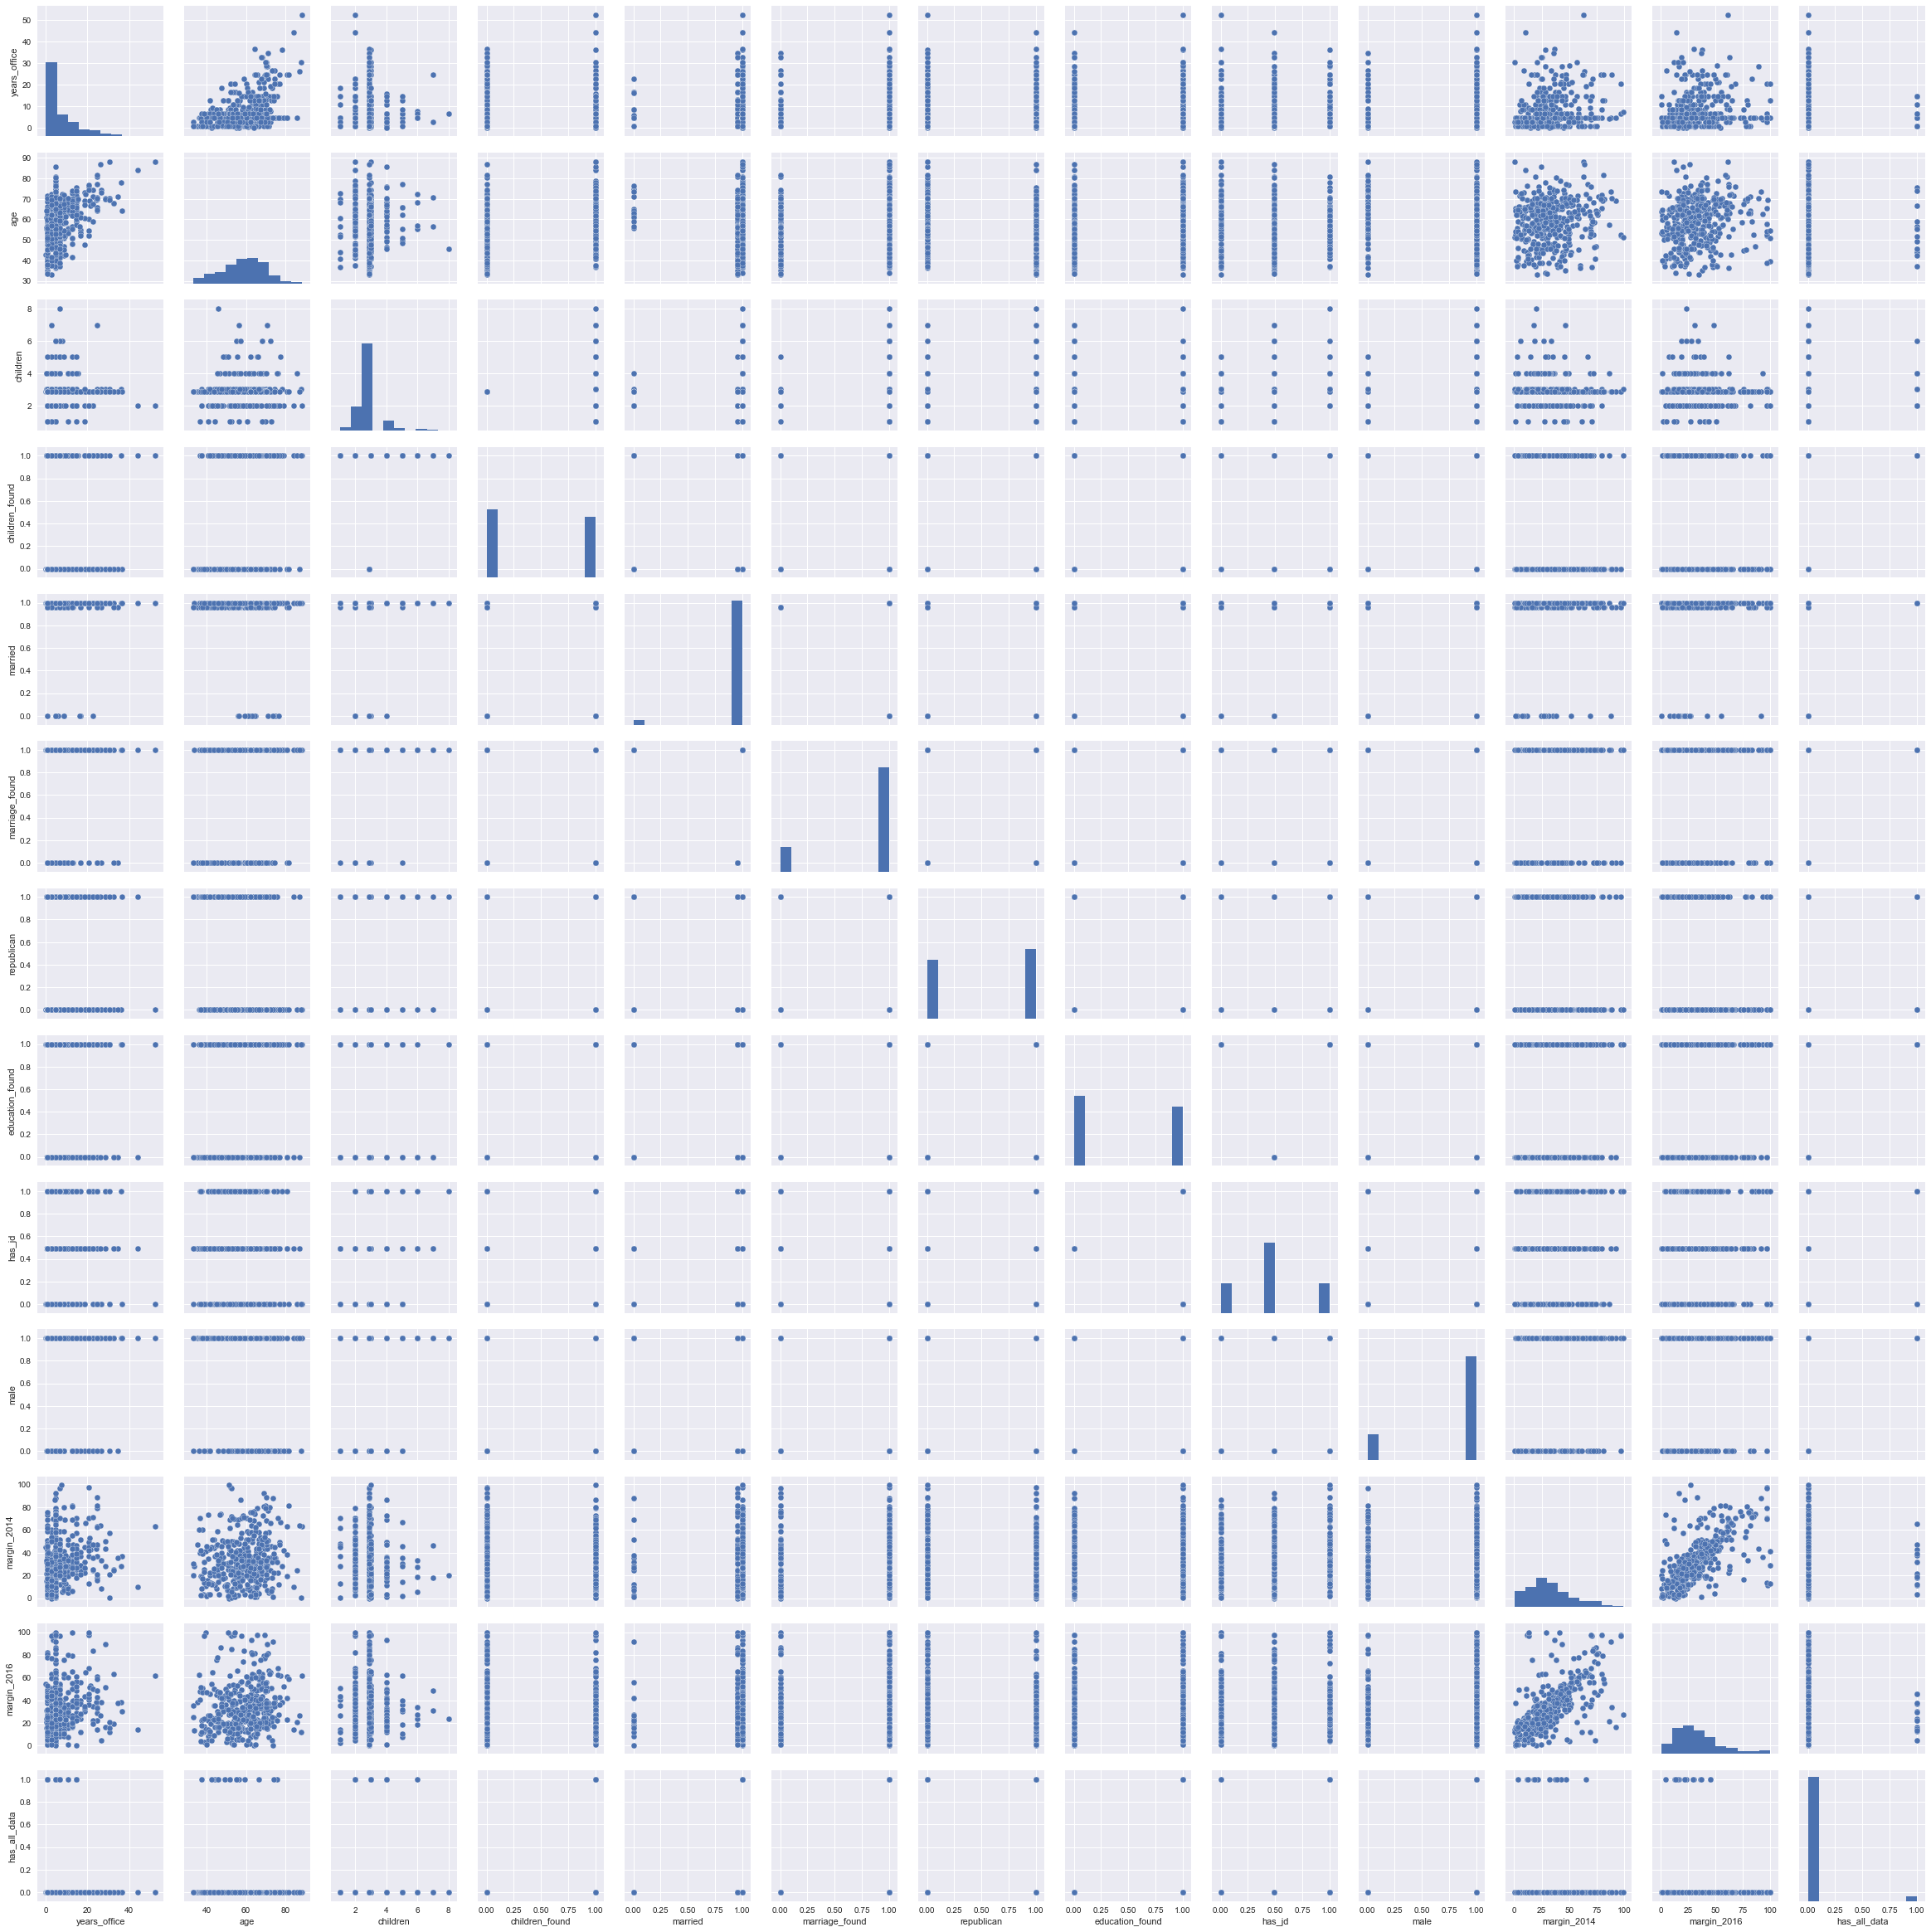

In [1419]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(df_test)

In [1557]:
df_test.corr()

years_office       age  children  children_found   married  \
years_office     1.000000      0.469419 -0.039802 -0.033647       -0.007255   
age              0.469419      1.000000  0.013161  0.042715       -0.112286   
children        -0.039802      0.013161  1.000000  0.004697        0.066674   
children_found  -0.033647      0.042715  0.004697  1.000000        0.008967   
married         -0.007255     -0.112286  0.066674  0.008967        1.000000   
marriage_found   0.113110      0.125167  0.019297  0.383843       -0.006834   
republican      -0.070475     -0.193635  0.141548  0.057511        0.057058   
education_found  0.183539      0.001218  0.030747  0.041815        0.130887   
has_jd           0.014730     -0.064202  0.044642 -0.010280        0.042055   
male             0.058615     -0.094809  0.081189  0.019024        0.040668   
margin_2014      0.166046      0.144061 -0.077692 -0.014722        0.027174   
margin_2016      0.130412      0.128317 -0.035260 -0.030988        0.064950   
has_all_data    -0.036321     -0.077422  0.045701  0.201288        0.045541   

                 marriage_found  republican  education_found    has_jd  \
years_office     0.113110       -0.070475    0.183539         0.014730   
age              0.125167       -0.193635    0.001218        -0.064202   
children         0.019297        0.141548    0.030747         0.044642   
children_found   0.383843        0.057511    0.041815        -0.010280   
married         -0.006834        0.057058    0.130887         0.042055   
marriage_found   1.000000        0.004656    0.033055         0.011422   
republican       0.004656        1.000000   -0.044717        -0.019157   
education_found  0.033055       -0.044717    1.000000         0.015321   
has_jd           0.011422       -0.019157    0.015321         1.000000   
male             0.072228        0.279588   -0.005687         0.157724   
margin_2014      0.013522       -0.077574    0.183980         0.059880   
margin_2016      0.018672       -0.232875    0.144086        -0.018717   
has_all_data     0.092416        0.037853    0.206348         0.201609   

                     male  margin_2014  margin_2016  has_all_data  
years_office     0.058615  0.166046     0.130412    -0.036321      
age             -0.094809  0.144061     0.128317    -0.077422      
children         0.081189 -0.077692    -0.035260     0.045701      
children_found   0.019024 -0.014722    -0.030988     0.201288      
married          0.040668  0.027174     0.064950     0.045541      
marriage_found   0.072228  0.013522     0.018672     0.092416      
republican       0.279588 -0.077574    -0.232875     0.037853      
education_found -0.005687  0.183980     0.144086     0.206348      
has_jd           0.157724  0.059880    -0.018717     0.201609      
male             1.000000 -0.031628    -0.035459     0.093881      
margin_2014     -0.031628  1.000000     0.629902    -0.048906      
margin_2016     -0.035459  0.629902     1.000000    -0.076423      
has_all_data     0.093881 -0.048906    -0.076423     1.000000

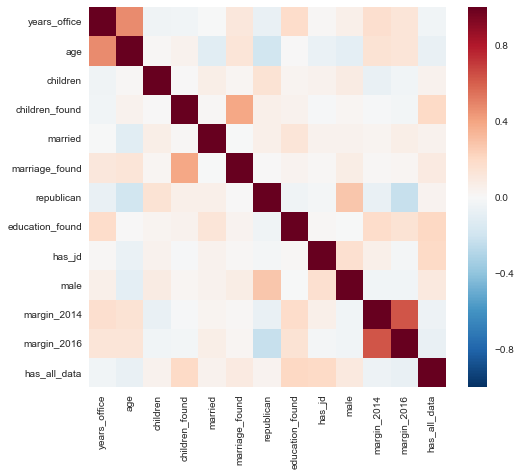

In [1556]:
sns.heatmap(df_test.corr());
plt.rcParams['figure.figsize']=(8,6);

In [1626]:
# get our features and independent variable
y = df_test['margin_2016']
X = df_test[['years_office', 'age', 'children', 'children_found', 'married', 'marriage_found', 'republican', 'education_found', 'has_jd', 'has_all_data', 'male', 'margin_2014']]

In [1515]:
# Get a baseline score to compare against regularization
lr = LinearRegression() 
# Split out data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Get the score
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.45320501962258453

In [1630]:
np.mean(cross_val_score(lr, X, y, cv=cross_valiator))

0.41487396846593166

In [1446]:
# now adjust the model for regularization and cross validation
alphas = np.arange(11.55, 11.65, 0.001)
ridge_model = RidgeCV(cv=5, alphas=alphas)

In [1447]:
ridge_model.fit(X, y)
ridge_model.score(X, y)

0.44175939900219646

In [1448]:
ridge_model.alpha_

11.594999999999976

In [1590]:
ridge_model_test = Ridge(alpha=11.595)

In [1618]:
cross_val_score(ridge_model_test, X, y, cv=5)

array([ 0.42707453,  0.15209391,  0.56360015,  0.52804695,  0.2383097 ])

In [1619]:
cross_valiator = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(ridge_model_test, X, y, cv=cross_valiator)

array([ 0.54730561,  0.3291131 ,  0.56935736,  0.34985675,  0.31107309])

In [1449]:
iter_alphas = np.arange(0.01, 50, 0.1)
iter_ridge_model = RidgeCV(cv=5, alphas=iter_alphas)

for column in X:
    X_test = X.drop(column, axis=1)
    iter_ridge_model.fit(X_test, y)
    print(iter_ridge_model.score(X_test, y))

0.441091328102
0.442028264785
0.440428066568
0.44213087208
0.439337656776
0.441773083454
0.403624261522
0.44162839323
0.438543175907
0.440636613064
0.439666014461
0.0879982718355


In [1450]:
for i in range(2,9):
    iter_fold_model = RidgeCV(cv=i, alphas=iter_alphas)
    iter_fold_model.fit(X, y)
    print(iter_fold_model.score(X, y))

0.441100477231
0.442847189431
0.440951243124
0.441756260783
0.43881941872
0.439381035748
0.440417833875


In [1477]:
features = list(df_test.columns.values)[1:12]
features.append('has_all_data')
features.sort()
features

['age',
 'children',
 'children_found',
 'education_found',
 'has_all_data',
 'has_jd',
 'male',
 'margin_2014',
 'marriage_found',
 'married',
 'republican',
 'years_office']

In [1483]:
model_str = 'margin_2016 ~ '
for feature in features:
    model_str += (feature + ' + ')
    
model_str = model_str[:-3]
model_str

'margin_2016 ~ age + children + children_found + education_found + has_all_data + has_jd + male + margin_2014 + marriage_found + married + republican + years_office'

In [1532]:
log_likelihoods = {}
adj_r_squared = {}

for i in range(len(features)):
    curr_model_str = 'margin_2016 ~ '
    
    for j in range(len(features)):
        if j != i:
            curr_model_str += (features[j] + ' + ')

    curr_model_str = curr_model_str[:-3]
    curr_y, curr_X = patsy.dmatrices(curr_model_str, data=df_test, return_type="dataframe")
    curr_model = sm.OLS(curr_y, curr_X)
    curr_fit = curr_model.fit()
    log_likelihoods[features[i]] = curr_fit.llf
    adj_r_squared[features[i]] = curr_fit.rsquared_adj

In [1498]:
log_likelihoods

{'age': -1691.8264944914115,
 'children': -1692.32260071326,
 'children_found': -1691.8615494358119,
 'education_found': -1691.9653844456993,
 'has_all_data': -1692.275667076276,
 'has_jd': -1693.2044136147354,
 'male': -1692.569997430802,
 'margin_2014': -1789.8130448878621,
 'marriage_found': -1691.8899817752254,
 'married': -1692.9729211275858,
 'republican': -1704.6951417141252,
 'years_office': -1691.8404115172741}

In [1533]:
adj_r_squared

{'age': 0.42798844705052974,
 'children': 0.42658535376692608,
 'children_found': 0.42788941708075234,
 'education_found': 0.42759598329763138,
 'has_all_data': 0.42671823927965136,
 'has_jd': 0.4240828995428555,
 'male': 0.42588437799821011,
 'margin_2014': 0.071989183779233246,
 'marriage_found': 0.42780908333118661,
 'married': 0.42474089611981325,
 'republican': 0.39045787301723212,
 'years_office': 0.4279491336029444}

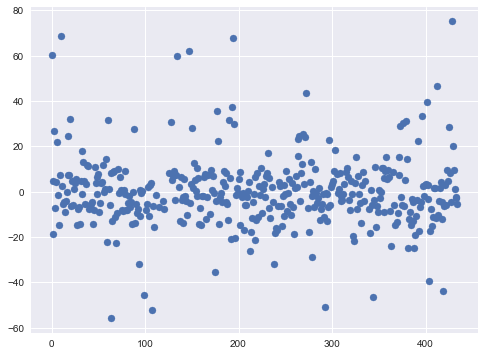

In [1579]:
plt.scatter(fit.resid.index, fit.resid)

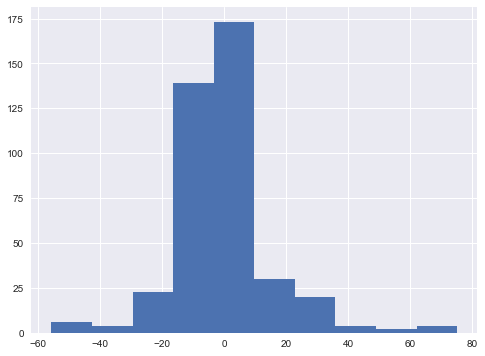

In [1581]:
plt.hist(fit.resid);

In [1495]:
# Create your feature matrix (X) and target vector (y)
y_sm, X_sm = patsy.dmatrices('margin_2016 ~ age + children + children_found + education_found + has_all_data + has_jd + male + margin_2014 + marriage_found + married + republican + years_office', data=df_test, return_type="dataframe")
# Create your model
model = sm.OLS(y_sm, X_sm)
#model = sm.OLS.fit_regularized(y_sm, X_sm, alpha=22.614, L1_wt=0.0)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            margin_2016   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     26.04
Date:                Tue, 18 Jul 2017   Prob (F-statistic):           5.82e-43
Time:                        14:41:38   Log-Likelihood:                -1691.8
No. Observations:                 405   AIC:                             3410.
Df Residuals:                     392   BIC:                             3462.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.1583      7.446      1.096      0.274      -6.482      22.798
age                -0.0024      0.087     -0.028      0.978      -0.174       0.169
children            0.9816      1.001      0.981      0.327      -0.986       2.949
children_found     -0.4642      1.772     -0.262      0.793      -3.948       3.019
education_found     0.8933      1.720      0.519      0.604      -2.488       4.275
has_all_data       -4.3837      4.696     -0.933      0.351     -13.617       4.850
has_jd             -4.0222      2.458     -1.636      0.103      -8.855       0.811
male                2.5711      2.141      1.201      0.230      -1.637       6.780
margin_2014         0.6308      0.040     15.619      0.000       0.551       0.710
marriage_found      0.7808      2.220      0.352      0.725      -3.584       5.145
married             6.4453      4.320      1.492      0.136      -2.047      14.938
republican         -8.7217      1.720     -5.072      0.000     -12.103      -5.341
years_office        0.0198      0.119      0.167      0.868      -0.214       0.254
==============================================================================
Omnibus:                       91.243   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              431.947
Skew:                           0.877   Prob(JB):                     1.60e-94
Kurtosis:                       7.745   Cond. No.                         694.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1732]:
y_test, X_test = patsy.dmatrices('margin_2016 ~ margin_2014 + republican', data=df_test, return_type="dataframe")
# Create your model
model = sm.OLS(y_test, X_test)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            margin_2016   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     152.2
Date:                Wed, 19 Jul 2017   Prob (F-statistic):           6.34e-50
Time:                        15:01:33   Log-Likelihood:                -1696.4
No. Observations:                 405   AIC:                             3399.
Df Residuals:                     402   BIC:                             3411.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      17.3437      1.788      9.702      0.000      13.829      20.858
margin_2014     0.6328      0.039     16.310      0.000       0.556       0.709
republican     -7.8592      1.602     -4.905      0.000     -11.009      -4.709
==============================================================================
Omnibus:                       98.115   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              512.103
Skew:                           0.921   Prob(JB):                    6.28e-112
Kurtosis:                       8.192   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1721]:
scaler = preprocessing.MinMaxScaler()
df_norm = df_test[['margin_2014', 'republican']]
df_norm = pd.DataFrame(scaler.fit_transform(df_norm), columns=df_norm.columns, index=df_test.index)

In [1723]:
df_norm.insert(0, 'margin_2016', df_test['margin_2016'])

In [1725]:
df_norm.describe()

margin_2016  margin_2014  republican
count  405.000000   405.000000   405.000000
mean   33.912346    0.330959     0.543210  
std    21.173441    0.207631     0.498746  
min    0.500000     0.000000     0.000000  
25%    18.900000    0.187500     0.000000  
50%    30.100000    0.298387     1.000000  
75%    44.300000    0.449597     1.000000  
max    99.900000    1.000000     1.000000

In [1727]:
df_norm.head(3)

margin_2016  margin_2014  republican
0  92.8         0.365927     1.0       
1  8.2          0.349798     1.0       
2  34.0         0.325605     1.0

In [1728]:
y_norm, X_norm = patsy.dmatrices('margin_2016 ~ margin_2014 + republican', data=df_norm, return_type="dataframe")
model_norm = sm.OLS(y_norm, X_norm)
fit_norm = model_norm.fit()
fit_norm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            margin_2016   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     152.2
Date:                Wed, 19 Jul 2017   Prob (F-statistic):           6.34e-50
Time:                        14:18:32   Log-Likelihood:                -1696.4
No. Observations:                 405   AIC:                             3399.
Df Residuals:                     402   BIC:                             3411.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      17.4070      1.785      9.753      0.000      13.899      20.916
margin_2014    62.7707      3.849     16.310      0.000      55.205      70.337
republican     -7.8592      1.602     -4.905      0.000     -11.009      -4.709
==============================================================================
Omnibus:                       98.115   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              512.103
Skew:                           0.921   Prob(JB):                    6.28e-112
Kurtosis:                       8.192   Cond. No.                         6.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1641]:
resid_df = pd.DataFrame()
resid_df['predict'] = fit.predict(X_test)

In [1651]:
resid_df['resid'] = y_test.margin_2016 - resid_df.predict

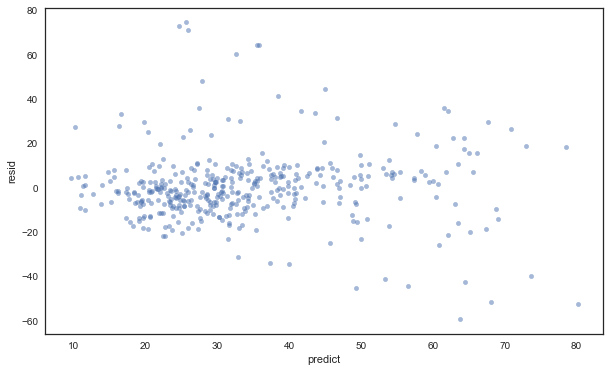

In [1653]:
with sns.axes_style('white'):
    plot = resid_df.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))

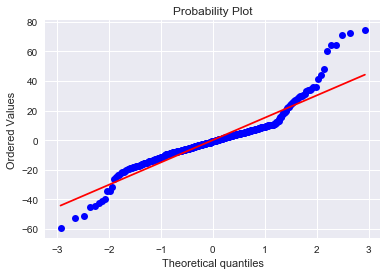

In [1678]:
stats.probplot(resid_df.resid, dist='norm', plot=plt)
plt.show();

In [ ]:
WLS_model = sm.WLS(y_test, X_test)
# Fit your model to your training set
WLS_fit = WLS_model.fit()
# Print summary statistics of the model's performance
WLS_fit.summary()

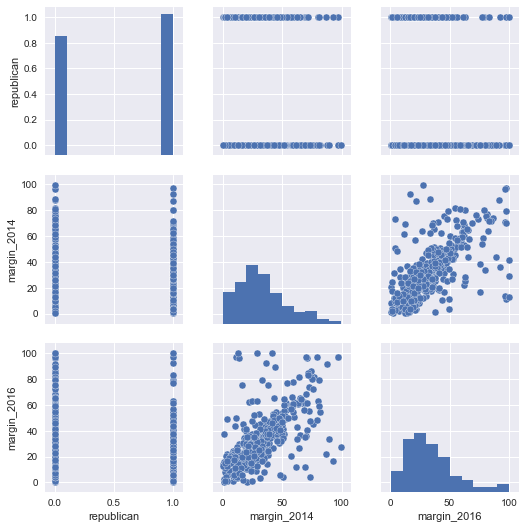

In [1655]:
sns.pairplot(df_test[['republican', 'margin_2014', 'margin_2016']])

In [1527]:
est = make_pipeline(PolynomialFeatures(2), LinearRegression())

In [1528]:
est.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [1529]:
r2_score(y_test, est.predict(X_test))

0.25246176713777013

In [1582]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(df_test[['margin_2014', 'republican']], df_test['margin_2016'], test_size=0.2)

In [1583]:
est.fit(X_poly_train, y_poly_train)
r2_score(y_poly_test, est.predict(X_poly_test))

0.37729390119478456

In [1769]:
margin_values = []

for i in range(50):
    df_local = df_test[(df_test.margin_2016 < 100 - i) & (df_test.margin_2016 > i)]
    y_local, X_local = patsy.dmatrices('margin_2016 ~ age + children + children_found + education_found + has_all_data + has_jd + male + margin_2014 + marriage_found + married + republican + years_office', data=df_local, return_type="dataframe")
    model_local = sm.OLS(y_local, X_local)
    fit_local = model_local.fit()
    margin_values.append([sms.omni_normtest(fit_local.resid)[1], i])
        
margin_values.sort(reverse=True)
margin_values

/Users/adouglas/Applications/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/Users/adouglas/Applications/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


[[0.98221596877949024, 44],
 [0.96253787942256863, 45],
 [0.87826718526854874, 47],
 [0.79098167455665802, 43],
 [0.58978853183974089, 48],
 [0.47800577704048364, 46],
 [0.44648515411369516, 33],
 [0.3634990418794859, 32],
 [0.35455874415070876, 31],
 [0.25140658118731402, 49],
 [0.24839639018481155, 30],
 [0.159056807940365, 29],
 [0.1258143029413836, 26],
 [0.12523283837734944, 27],
 [0.12124348656119129, 35],
 [0.11865366550273208, 42],
 [0.11289102557736141, 36],
 [0.10787131070557759, 28],
 [0.10555736882213071, 34],
 [0.087307734717491287, 25],
 [0.070740889473984436, 41],
 [0.069911425504782396, 37],
 [0.069813415904080675, 40],
 [0.029321792237950648, 38],
 [0.0097171408204170164, 39],
 [5.6498929314469941e-05, 24],
 [2.5775278807407537e-05, 23],
 [2.7618773785151503e-06, 21],
 [8.2640813583623953e-07, 22],
 [7.8811036315676624e-07, 16],
 [6.7814274551578871e-07, 20],
 [5.0870054158994399e-07, 15],
 [4.0424079359594865e-07, 17],
 [4.0237075917129433e-07, 18],
 [4.01633100914863

In [1770]:
df_local_best = df_test[(df_test.margin_2016 < 75) & (df_test.margin_2016 > 25)]
y_local, X_local = patsy.dmatrices('margin_2016 ~ age + children + children_found + education_found + has_all_data + has_jd + male + margin_2014 + marriage_found + married + republican + years_office', data=df_local_best, return_type="dataframe")
#y_local, X_local = patsy.dmatrices('margin_2016 ~ margin_2014 + married + republican', data=df_local_best, return_type="dataframe")
model_local = sm.OLS(y_local, X_local)
fit_local = model_local.fit()
fit_local.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            margin_2016   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     9.671
Date:                Wed, 19 Jul 2017   Prob (F-statistic):           9.44e-15
Time:                        15:54:39   Log-Likelihood:                -772.01
No. Observations:                 213   AIC:                             1570.
Df Residuals:                     200   BIC:                             1614.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          28.8738      7.192      4.015      0.000      14.693      43.055
age                 0.0199      0.073      0.272      0.786      -0.124       0.164
children            0.2463      0.793      0.311      0.756      -1.317       1.810
children_found      0.0234      1.409      0.017      0.987      -2.756       2.802
education_found    -0.6710      1.351     -0.497      0.620      -3.335       1.993
has_all_data       -2.6505      4.025     -0.659      0.511     -10.587       5.286
has_jd             -2.3918      1.898     -1.260      0.209      -6.135       1.352
male               -2.5938      1.783     -1.454      0.147      -6.111       0.923
margin_2014         0.3606      0.040      8.963      0.000       0.281       0.440
marriage_found      0.5730      1.939      0.296      0.768      -3.250       4.396
married             2.2045      4.811      0.458      0.647      -7.283      11.692
republican         -4.5400      1.457     -3.116      0.002      -7.413      -1.667
years_office       -0.0608      0.091     -0.664      0.507      -0.241       0.120
==============================================================================
Omnibus:                        4.877   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.087   Jarque-Bera (JB):                6.337
Skew:                           0.102   Prob(JB):                       0.0421
Kurtosis:                       3.820   Cond. No.                         923.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model with features taken out

In [1631]:
def model_score(features: list):
    alphas = np.arange(0.1, 50.0, 0.1)
    cross_valiator = KFold(n_splits=5, shuffle=True, random_state=42)
    y = df_test['margin_2016']
    X = df_test[features]
    
    ridge_cv_model = RidgeCV(cv=cross_valiator, alphas=alphas, normalize=True)
    ridge_cv_model.fit(X, y)
    
    ridge_model = Ridge(alpha=ridge_cv_model.alpha_)
    return np.mean(cross_val_score(ridge_model, X, y, cv=cross_valiator))

In [1632]:
print(model_score(features))

0.422689224044


In [ ]:
model_summary(features)

In [1633]:
# take out age, years_office, children_found, and education_found
print(model_score(['children', 'has_all_data', 'has_jd', 'male', 'margin_2014', 'marriage_found', 'married','republican']))

0.435790317699


In [ ]:
model_summary(['children', 'has_all_data', 'has_jd', 'male', 'margin_2014', 'marriage_found', 'married','republican'])

In [1634]:
# take out age, years_office, children_found, education_found, children, has_all_data, marriage_found
print(model_score(['has_jd', 'male', 'margin_2014', 'married','republican']))

0.437705438765


In [ ]:
model_summary(['has_jd', 'male', 'margin_2014', 'married','republican'])

In [1635]:
# take out age, years_office, children_found, education_found, children, has_all_data, marriage_found, male
print(model_score(['has_jd', 'margin_2014', 'married','republican']))

0.437576250413


In [1636]:
print(model_score(['margin_2014', 'republican']))

0.435542487427


In [1637]:
model_summary(['margin_2014', 'republican'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            margin_2016   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     152.2
Date:                Wed, 19 Jul 2017   Prob (F-statistic):           6.34e-50
Time:                        11:26:16   Log-Likelihood:                -1696.4
No. Observations:                 405   AIC:                             3399.
Df Residuals:                     402   BIC:                             3411.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      17.3437      1.788      9.702      0.000      13.829      20.858
margin_2014     0.6328      0.039     16.310      0.000       0.556       0.709
republican     -7.8592      1.602     -4.905      0.000     -11.009      -4.709
==============================================================================
Omnibus:                       98.115   Durbin-Watson:                   1.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              512.103
Skew:                           0.921   Prob(JB):                    6.28e-112
Kurtosis:                       8.192   Cond. No.                         103.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1565]:
def model_summary(features: list):
    model_str = 'margin_2016 ~ '
    for feature in features:
        model_str += (feature + ' + ')
    model_str = model_str[:-3]
    
    curr_y, curr_X = patsy.dmatrices(model_str, data=df_test, return_type="dataframe")
    curr_model = sm.OLS(curr_y, curr_X)
    curr_fit = curr_model.fit()
    return curr_fit.summary()

In [1559]:
features

['age',
 'children',
 'children_found',
 'education_found',
 'has_all_data',
 'has_jd',
 'male',
 'margin_2014',
 'marriage_found',
 'married',
 'republican',
 'years_office']